## <a> 1) Web Scraping

### a) Importing Libraries

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [2]:
import pandas as pd
import numpy as np
import pickle
from time import sleep, strftime
from random import randint
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import smtplib
from email.mime.multipart import MIMEMultipart


#import warning library
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


#Importing Miscellaneous Libraries
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option('display.width', None)

# Importing libraries for evaluation of model
from sklearn.metrics import *
from math import sqrt

# Importing libraries for model building
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

### b) Web scraping

In [3]:
# Defining the chromedriver path
chromedriver_path = 'C:/Users/Saily/.wdm/drivers/chromedriver/win32/89.0.4389.23/chromedriver.exe'

driver = webdriver.Chrome(executable_path=chromedriver_path) # This will open the Chrome window
sleep(2)

In [4]:
# Let us store all the cookies of kayak site to take care of recaptch aerror
pickle.dump( driver.get_cookies() , open("cookies.pkl","wb"))
cookies = pickle.load(open("cookies.pkl", "rb"))
for cookie in cookies:
    driver.add_cookie(cookie)
sleep(2)

In [5]:
# Load more results to maximize the scraping

def load_more():
    try:
        more_results = '//a[@class = "moreButton"]'/''
        driver.find_element_by_xpath(more_results).click()
        print('sleeping.....')
        sleep(randint(25,35))
    except:
        pass

In [6]:
def start_kayak(city_from, city_to, date_start, date_end):
    """City codes - it's the IATA codes!
    Date format -  YYYY-MM-DD"""
    
    kayak = ('https://www.kayak.co.in/flights/' + city_from + '-' + city_to +
             '/' + date_start + '-flexible/' + date_end + '-flexible?sort=bestflight_a')
    driver.get(kayak)
    sleep(randint(8,10))
    
    # sometimes a popup shows up, so we can use a try statement to check it and close
    try:
        xp_popup_close = '//button[contains(@id,"-dialog-close") and contains(@class,"Button-No-Standard-Style close inside darkIcon ")]'
        l = len(driver.find_elements_by_xpath(xp_popup_close))
        driver.find_elements_by_xpath(xp_popup_close)[l-1].click()
    except Exception as e:
        pass
    sleep(randint(60,95))
    print('loading more.....')
    
#     load_more()

    print('starting first scrape.....')
    df_flights_best = page_scrape()
    df_flights_best['sort'] = 'Cheap'
    sleep(randint(60,80))
    
    
    print('switching to cheapest results.....')
    cheap_results = '//a[@data-code = "price"]'
    driver.find_element_by_xpath(cheap_results).click()
    sleep(randint(60,90))
    print('loading more.....')
    
#     load_more()
    
    print('starting second scrape.....')
    df_flights_cheap = page_scrape()
    df_flights_cheap['sort'] = 'Best'
    sleep(randint(60,80))
    
    print('switching to best results.....')
    best_results = '//a[@data-code = "bestflight"]'
    driver.find_element_by_xpath(best_results).click()  
    sleep(randint(60,90))
    print('loading more.....')
    
#     load_more()
    
    print('starting third scrape.....')
    df_flights_fast = page_scrape()
    df_flights_fast['sort'] = 'fast'
    sleep(randint(60,80))
    
    print('switching to quickest results.....')
    quick_results = '//a[@data-code = "duration"]'
    driver.find_element_by_xpath(quick_results).click()  
    sleep(randint(60,90))
    print('loading more.....')
    
    
    # saving a new dataframe as an excel file. the name is custom made to your cities and dates
    final_df = df_flights_cheap.append(df_flights_best).append(df_flights_fast)
    final_df.to_excel('flights_{}-{}_from_{}_to_{}.xlsx'.format(city_from, city_to, 
                                                                                   date_start, date_end), index=False)
    print('saved df.....')
    

In [7]:
def page_scrape():
    """This function takes care of the scraping part"""    
    xp_sections = '//*[@class="section times"]'
    sections = driver.find_elements_by_xpath(xp_sections)
    sections_list = [value.text for value in sections]
    sections_list = [i for i in sections_list if i]
    section_a_list = sections_list[::2] # This is to separate the two flights
    section_b_list = sections_list[1::2] # This is to separate the two flights
    
    # If we run into recaptcha, we might end up getting an empty sections_list & thus affect our entire scraping process.
    # To address this issue, I have used SystemExit to keep a check on empty list.
    if section_a_list == []:
        raise SystemExit
    
    a_time = []
    a_city_names = []
    for n in section_a_list:
        # Separate the time from the cities
        a_city_names.append(' '.join(n.split()[3:5]))
        a_time.append(''.join(n.split()[0:3]))
    b_time = []
    b_city_names = []
    for n in section_b_list:
        # Separate the time from the cities
        b_city_names.append(' '.join(n.split()[3:5]))
        b_time.append(''.join(n.split()[0:3]))
        
#####################################        
    xp_airlines = '//div[@class="section codeshares allow-airlines"]'
    airline = driver.find_elements_by_xpath(xp_airlines)
    airline_list = [value.text for value in airline]
    airline_list = [i for i in airline_list if i]
    new_airline = [i.split(',') for i in airline_list] #cnvt to list
    a_airline = [i[0] for i in new_airline]
    b_airline = []
    for i in new_airline:
        if len(i) > 1:
            b_airline.append(i[1])
        else:
            b_airline.append(i[0])

    b_airline = [i.strip() for i in b_airline]
    
#####################################    
#
    xp_dates = '//div[contains(@class,"section stacked-carriers with-date") or contains(@class,"section carrier with-date")]'
    
    dates = driver.find_elements_by_xpath(xp_dates)
    dates_list = [value.text for value in dates]
    dates_list = [i for i in dates_list if i]
    a_date_list = dates_list[0::2]
    b_date_list = dates_list[1::2]
    a_date_list = [date + "/2021" if len(date) != 0 else  '' for date in a_date_list]
    b_date_list = [date + "/2021" if len(date) != 0 else  '' for date in b_date_list]
    
    from datetime import datetime
    a_DATE = [datetime.strptime(i,'%d/%m/%Y').date() if len(i) != 0 else  '' for i in a_date_list]
    a_weekday = [i.strftime("%A") if i != '' else  '' for i in a_DATE]
    a_date = [i.strftime("%d") if i != '' else  '' for i in a_DATE]
    a_month = [i.strftime("%B") if i != '' else  '' for i in a_DATE]
    a_year = [i.strftime("%Y") if i != '' else  '' for i in a_DATE]

    b_DATE = [datetime.strptime(i,'%d/%m/%Y').date() if len(i) != 0 else  '' for i in b_date_list]
    b_weekday = [i.strftime("%A") if i != '' else  '' for i in b_DATE]
    b_date = [i.strftime("%d") if i != '' else  '' for i in b_DATE]
    b_month = [i.strftime("%B") if i != '' else  '' for i in b_DATE]
    b_year = [i.strftime("%Y") if i != '' else  '' for i in b_DATE]
    
######################################   
    
    # getting the prices
    xp_prices = '//a[@class="booking-link "]/span[@class="price option-text"]/span[@class="price-text"][not(contains(@id,"extra-info"))]'
    prices = driver.find_elements_by_xpath(xp_prices)
    prices_list = [price.text.replace('₹','') for price in prices if price.text != '']
    
    prices_list = [price.strip() for price in prices_list]
    prices_list = [price.replace(',', '') for price in prices_list]
    prices_list = [int(i) for i in prices_list]

#####################################

    # Type of journey - direct or with stops?
    xp_journey = '//div[@class="section stops"]/div[1]'
    journey = driver.find_elements_by_xpath(xp_journey)
    journey_type_list = [stop.text.replace('n','0') for stop in journey]
    journey_type_list = [i for i in journey_type_list if i]
    a_type_journey = journey_type_list[::2]
    b_type_journey = journey_type_list[1::2]

####################################

    xp_stops_cities = '//div[@class="section times"]/div[2]'
    stops_cities = driver.find_elements_by_xpath(xp_stops_cities)
    stops_cities_list = [stop.text.replace('\n','') for stop in stops_cities]
    stops_cities_list = [i for i in stops_cities_list if i]
    a_stop_name_list = stops_cities_list[::2]
    b_stop_name_list = stops_cities_list[1::2]

####################################
    
    # this part gets me the the departure and arrival times, for both legs
    xp_schedule = '//div[@class="section duration allow-multi-modal-icons"]'
    schedules = driver.find_elements_by_xpath(xp_schedule)
    hours_list = [i.text for i in schedules]
    hours_list = [i for i in hours_list if i]
    a_travel_time = hours_list[::2]
    b_travel_time = hours_list[1::2]
    
#####################################
    # Let us find out the stop names if the flights are not direct
    xp_dates = '//div[@class="container"]/div[4]'
    dates = driver.find_elements_by_xpath(xp_dates)
    dates_list = [value.text for value in dates]
    dates_list = [i for i in dates_list if i]  
    stop_name_list = []
    for i in dates_list:
        if i == 'direct':
            stop_name_list.append(0)
        else:
            stop_name_list.append(i.split("\n", maxsplit=1)[1])

    a_stop_name_list = stop_name_list[::2]
    b_stop_name_list = stop_name_list[1::2]
    
    
    d = {'Out_Date': a_date_list,
                               'Out_Day': a_date,
                               'Out_Weekday': a_weekday,
                               'Out_Month': a_month,
                               'out_Year': a_year,
                               'Out_Time': a_time,
                               'Out_Cities': a_city_names,
                               'Out_Airline': a_airline,
                               'Return_Date': b_date_list,
                               'Return_Day': b_date,
                               'Return_Weekday': b_weekday,
                               'Return_Month': b_month,
                               'Return_Year': b_year,
                               'Return_Time': b_time,
                               'Return_Cities': b_city_names,
                               'Return_Airline': b_airline, 
                               'Out_Travel_Time': a_travel_time,
                               'Return_Travel_Time': b_travel_time,
                               'Out_Journey_Type': a_type_journey,
                               'Return_Journey_Type': b_type_journey,
         
                               'Out_Stop_Cities': a_stop_name_list,
                               
                               'Return_Stop_Cities': a_stop_name_list,
                               'Price': prices_list}
    
    flights_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in d.items()]))
#     flights_df = pd.DataFrame(dict([(k,pd.Series(v,dtype=pd.StringDtype())) for k,v in d.items()]))
    
    flights_df['timestamp'] = strftime("%Y%m%d-%H%M") # so we can know when it was scraped
    return flights_df

In [34]:
# Let us start scraping the desired journeys
city_from = input('Origin? ')
city_to = input('Destination? ')
date_start = input('Departure date? Please use YYYY-MM-DD format only ')
date_end = input('Return when? Please use YYYY-MM-DD format only ')


# city_from = 'nagpur'
# city_to = 'chennai' 
# date_start = '2021-05-24'
# date_end = '2021-06-18'

start_kayak(city_from, city_to, date_start, date_end)
# for n in range(0,5):
#     start_kayak(city_from, city_to, date_start, date_end)
#     print('iteration {} was complete @ {}'.format(n, strftime("%Y%m%d-%H%M")))
    
# #     # Wait 4 hours
#     sleep(60*60*4)
#     print('sleep finished.....')

loading more.....
starting first scrape.....
switching to cheapest results.....
loading more.....
starting second scrape.....
switching to best results.....
loading more.....
starting third scrape.....
switching to quickest results.....
loading more.....
saved df.....


### c) Concatenating all the scraped journeys

In [35]:
import glob,os

# Reading all the paths
path = r'C:\Users\Saily\Desktop\Technocolabs internship'

# Reading all the paths
all_files = glob.glob(path + "/*.xlsx")

# Empty list to add all the dataframes
l = []

#loop to read each file with the file with the path
for filename in all_files:

    #Reading each file as pandas dataframe
    df = pd.read_excel(filename,index_col = None)
    #Append the final dataframe into list -'l'
    l.append(df)

##creating a final dataframe by joining all the df's in the list -l
df = pd.concat(l,axis=0,ignore_index=True,sort = False)
df.head()


Out_Date  Out_Day Out_Weekday Out_Month  out_Year     Out_Time  \
0  6/5/2021        6    Thursday       May      2021  21:50–23:10   
1  6/5/2021        6    Thursday       May      2021  19:15–14:30   
2  6/5/2021        6    Thursday       May      2021  08:25–09:45   
3  6/5/2021        6    Thursday       May      2021  21:50–23:10   
4  6/5/2021        6    Thursday       May      2021  08:25–09:45   

    Out_Cities Out_Airline Return_Date  Return_Day Return_Weekday  \
0  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
1       +1 GOI   Air India   26/5/2021          26      Wednesday   
2  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
3  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
4  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   

  Return_Month  Return_Year  Return_Time  Return_Cities Return_Airline  \
0          May         2021  17:10–21:10  BLR Bengaluru         IndiGo   
1          May         2021  06:30–10:50  BLR Bengaluru      Air India   
2          May         2021  06:20–07:45  BLR Bengaluru         IndiGo   
3          May         2021  06:20–07:45  BLR Bengaluru         IndiGo   
4          May         2021  20:05–21:30  BLR Bengaluru         IndiGo   

  Out_Travel_Time Return_Travel_Time Out_Journey_Type Return_Journey_Type  \
0          1h 20m             4h 00m           direct              1 stop   
1         19h 15m             4h 20m           1 stop              1 stop   
2          1h 20m             1h 25m           direct              direct   
3          1h 20m             1h 25m           direct              direct   
4          1h 20m             1h 25m           direct              direct   

  Out_Stop_Cities Return_Stop_Cities  Price      timestamp  sort  
0               0                  0   6242  20210416-0038  Best  
1             MYQ                MYQ   5100  20210416-0038  Best  
2               0                  0   5995  20210416-0038  Best  
3               0                  0   5995  20210416-0038  Best  
4               0                  0   5995  20210416-0038  Best

In [40]:
# saving the dataframe
df.to_excel('Flight_df.xls')

## <a> 2) Exploratory data analysis

### a) Importing dataset

Since data is in form of excel file we have to use pandas read_excel to load the data. After loading it is important to check the complete information of data as it can indication many of the hidden infomation such as null values in a column or a row
Check whether any null values are there or not. if it is present then following can be done,
 - Imputing data using Imputation method in sklearn
 - Filling NaN values with mean, median and mode using fillna() method

In [3]:
# Reading dataset
df = pd.read_excel("Flight_df.xls")

In [4]:
df.head()

Unnamed: 0  Out_Date  Out_Day Out_Weekday Out_Month  out_Year     Out_Time  \
0           0  6/5/2021        6    Thursday       May      2021  21:50–23:10   
1           1  6/5/2021        6    Thursday       May      2021  19:15–14:30   
2           2  6/5/2021        6    Thursday       May      2021  08:25–09:45   
3           3  6/5/2021        6    Thursday       May      2021  21:50–23:10   
4           4  6/5/2021        6    Thursday       May      2021  08:25–09:45   

    Out_Cities Out_Airline Return_Date  Return_Day Return_Weekday  \
0  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
1       +1 GOI   Air India   26/5/2021          26      Wednesday   
2  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
3  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   
4  IXM Madurai      IndiGo   26/5/2021          26      Wednesday   

  Return_Month  Return_Year  Return_Time  Return_Cities Return_Airline  \
0          May         2021  17:10–21:10  BLR Bengaluru         IndiGo   
1          May         2021  06:30–10:50  BLR Bengaluru      Air India   
2          May         2021  06:20–07:45  BLR Bengaluru         IndiGo   
3          May         2021  06:20–07:45  BLR Bengaluru         IndiGo   
4          May         2021  20:05–21:30  BLR Bengaluru         IndiGo   

  Out_Travel_Time Return_Travel_Time Out_Journey_Type Return_Journey_Type  \
0          1h 20m             4h 00m           direct              1 stop   
1         19h 15m             4h 20m           1 stop              1 stop   
2          1h 20m             1h 25m           direct              direct   
3          1h 20m             1h 25m           direct              direct   
4          1h 20m             1h 25m           direct              direct   

  Out_Stop_Cities Return_Stop_Cities  Price      timestamp  sort  
0               0                  0   6242  20210416-0038  Best  
1             MYQ                MYQ   5100  20210416-0038  Best  
2               0                  0   5995  20210416-0038  Best  
3               0                  0   5995  20210416-0038  Best  
4               0                  0   5995  20210416-0038  Best

In [5]:
df.shape

(6650, 26)

In [6]:
df.columns

Index(['Unnamed: 0', 'Out_Date', 'Out_Day', 'Out_Weekday', 'Out_Month',
       'out_Year', 'Out_Time', 'Out_Cities', 'Out_Airline', 'Return_Date',
       'Return_Day', 'Return_Weekday', 'Return_Month', 'Return_Year',
       'Return_Time', 'Return_Cities', 'Return_Airline', 'Out_Travel_Time',
       'Return_Travel_Time', 'Out_Journey_Type', 'Return_Journey_Type',
       'Out_Stop_Cities', 'Return_Stop_Cities', 'Price', 'timestamp', 'sort'],
      dtype='object')

In [7]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
!pip install pandas-profiling

  Using cached https://files.pythonhosted.org/packages/3b/a3/34519d16e5ebe69bad30c5526deea2c3912634ced7f9b5e6e0bb9dbbd567/pandas_profiling-3.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/48/9b/dc3bbfc44d851632df958acf9d47e4de662c6bbd238e46798d555d427b27/Jinja2-3.0.0-py3-none-any.whl
  Found existing installation: Jinja2 2.10.3
    Uninstalling Jinja2-2.10.3:
      Successfully uninstalled Jinja2-2.10.3


In [9]:
import pandas_profiling as pp 
profile = pp.ProfileReport(df) 
profile.to_file("output.html")
profile

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Out_Date             6650 non-null   object
 1   Out_Day              6650 non-null   int64 
 2   Out_Weekday          6650 non-null   object
 3   Out_Month            6650 non-null   object
 4   out_Year             6650 non-null   int64 
 5   Out_Time             6650 non-null   object
 6   Out_Cities           6650 non-null   object
 7   Out_Airline          6650 non-null   object
 8   Return_Date          6650 non-null   object
 9   Return_Day           6650 non-null   int64 
 10  Return_Weekday       6650 non-null   object
 11  Return_Month         6650 non-null   object
 12  Return_Year          6650 non-null   int64 
 13  Return_Time          6650 non-null   object
 14  Return_Cities        6650 non-null   object
 15  Return_Airline       6650 non-null   object
 16  Out_Tr

In [11]:
# Let us chk for missing values
df.isna().values.any()

False

<a> We can observe that there are no missing values

In [12]:
df.dtypes

Out_Date               object
Out_Day                 int64
Out_Weekday            object
Out_Month              object
out_Year                int64
Out_Time               object
Out_Cities             object
Out_Airline            object
Return_Date            object
Return_Day              int64
Return_Weekday         object
Return_Month           object
Return_Year             int64
Return_Time            object
Return_Cities          object
Return_Airline         object
Out_Travel_Time        object
Return_Travel_Time     object
Out_Journey_Type       object
Return_Journey_Type    object
Out_Stop_Cities        object
Return_Stop_Cities     object
Price                   int64
timestamp              object
sort                   object
dtype: object

In [13]:
df = df.astype({"Out_Day":'int64', "out_Year":'int64','Return_Day':'int64','Return_Year':'int64','Price':'int64'})

In [14]:
df.describe()

Out_Day  out_Year   Return_Day  Return_Year          Price
count  6650.000000    6650.0  6650.000000       6650.0    6650.000000
mean     14.640752    2021.0    15.741053       2021.0   10363.778797
std       9.213619       0.0     9.399620          0.0    9022.436486
min       1.000000    2021.0     1.000000       2021.0    2267.000000
25%       5.000000    2021.0     9.000000       2021.0    6783.000000
50%      15.000000    2021.0    16.000000       2021.0    8858.000000
75%      24.000000    2021.0    24.000000       2021.0   11875.000000
max      31.000000    2021.0    31.000000       2021.0  110493.000000

### b) Data Understanding 

In [15]:
df['Out_Month'] = pd.to_datetime(df.Out_Date,format="%d/%m/%Y").dt.month #Converting the Out_Month to the month number.

In [16]:
df["Price"] = df["Price"]*0.56 #Reducing the price to one way price

In [17]:
df.drop(['Return_Date'], axis=1, inplace=True) #Dropping the return type.

In [18]:
df.head()

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year     Out_Time  \
0  6/5/2021        6    Thursday          5      2021  21:50–23:10   
1  6/5/2021        6    Thursday          5      2021  19:15–14:30   
2  6/5/2021        6    Thursday          5      2021  08:25–09:45   
3  6/5/2021        6    Thursday          5      2021  21:50–23:10   
4  6/5/2021        6    Thursday          5      2021  08:25–09:45   

    Out_Cities Out_Airline  Return_Day Return_Weekday Return_Month  \
0  IXM Madurai      IndiGo          26      Wednesday          May   
1       +1 GOI   Air India          26      Wednesday          May   
2  IXM Madurai      IndiGo          26      Wednesday          May   
3  IXM Madurai      IndiGo          26      Wednesday          May   
4  IXM Madurai      IndiGo          26      Wednesday          May   

   Return_Year  Return_Time  Return_Cities Return_Airline Out_Travel_Time  \
0         2021  17:10–21:10  BLR Bengaluru         IndiGo          1h 20m   
1         2021  06:30–10:50  BLR Bengaluru      Air India         19h 15m   
2         2021  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
3         2021  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
4         2021  20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   

  Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
0             4h 00m           direct              1 stop               0   
1             4h 20m           1 stop              1 stop             MYQ   
2             1h 25m           direct              direct               0   
3             1h 25m           direct              direct               0   
4             1h 25m           direct              direct               0   

  Return_Stop_Cities    Price      timestamp  sort  
0                  0  3495.52  20210416-0038  Best  
1                MYQ  2856.00  20210416-0038  Best  
2                  0  3357.20  20210416-0038  Best  
3                  0  3357.20  20210416-0038  Best  
4                  0  3357.20  20210416-0038  Best

In [19]:
df['Out_Month'].value_counts() #Finding the no. of months in the dataset.

5     2600
8     1089
4      895
6      684
7      586
9      558
11     136
10      56
12      46
Name: Out_Month, dtype: int64

In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True) #Converting the timestamp to date and time 

In [21]:
df.head()

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year     Out_Time  \
0  6/5/2021        6    Thursday          5      2021  21:50–23:10   
1  6/5/2021        6    Thursday          5      2021  19:15–14:30   
2  6/5/2021        6    Thursday          5      2021  08:25–09:45   
3  6/5/2021        6    Thursday          5      2021  21:50–23:10   
4  6/5/2021        6    Thursday          5      2021  08:25–09:45   

    Out_Cities Out_Airline  Return_Day Return_Weekday Return_Month  \
0  IXM Madurai      IndiGo          26      Wednesday          May   
1       +1 GOI   Air India          26      Wednesday          May   
2  IXM Madurai      IndiGo          26      Wednesday          May   
3  IXM Madurai      IndiGo          26      Wednesday          May   
4  IXM Madurai      IndiGo          26      Wednesday          May   

   Return_Year  Return_Time  Return_Cities Return_Airline Out_Travel_Time  \
0         2021  17:10–21:10  BLR Bengaluru         IndiGo          1h 20m   
1         2021  06:30–10:50  BLR Bengaluru      Air India         19h 15m   
2         2021  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
3         2021  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
4         2021  20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   

  Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
0             4h 00m           direct              1 stop               0   
1             4h 20m           1 stop              1 stop             MYQ   
2             1h 25m           direct              direct               0   
3             1h 25m           direct              direct               0   
4             1h 25m           direct              direct               0   

  Return_Stop_Cities    Price           timestamp  sort  
0                  0  3495.52 2021-04-16 00:38:00  Best  
1                MYQ  2856.00 2021-04-16 00:38:00  Best  
2                  0  3357.20 2021-04-16 00:38:00  Best  
3                  0  3357.20 2021-04-16 00:38:00  Best  
4                  0  3357.20 2021-04-16 00:38:00  Best

In [22]:
# Get the departure time and skiping the arrival time as it can be predict from the Out_Travel_Time
time = list(df["Out_Time"])
duration=[]
for i in range(len(time)):
    duration.append(time[i].split(sep='–')[0])
df["Out_Time"]=duration

In [23]:
df["Out_Time"].head()

0    21:50
1    19:15
2    08:25
3    21:50
4    08:25
Name: Out_Time, dtype: object

In [24]:
# Adding sec to Out_Time and storing it in the Out_Time1 for later use 
time = list(df['Out_Time']) 
for i in range(len(time)):
    time[i] = time[i] + ':00'
df['Out_Time1'] = time

In [25]:
df.head()

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year Out_Time   Out_Cities  \
0  6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
1  6/5/2021        6    Thursday          5      2021    19:15       +1 GOI   
2  6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   
3  6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
4  6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   

  Out_Airline  Return_Day Return_Weekday Return_Month  Return_Year  \
0      IndiGo          26      Wednesday          May         2021   
1   Air India          26      Wednesday          May         2021   
2      IndiGo          26      Wednesday          May         2021   
3      IndiGo          26      Wednesday          May         2021   
4      IndiGo          26      Wednesday          May         2021   

   Return_Time  Return_Cities Return_Airline Out_Travel_Time  \
0  17:10–21:10  BLR Bengaluru         IndiGo          1h 20m   
1  06:30–10:50  BLR Bengaluru      Air India         19h 15m   
2  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
3  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
4  20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   

  Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
0             4h 00m           direct              1 stop               0   
1             4h 20m           1 stop              1 stop             MYQ   
2             1h 25m           direct              direct               0   
3             1h 25m           direct              direct               0   
4             1h 25m           direct              direct               0   

  Return_Stop_Cities    Price           timestamp  sort Out_Time1  
0                  0  3495.52 2021-04-16 00:38:00  Best  21:50:00  
1                MYQ  2856.00 2021-04-16 00:38:00  Best  19:15:00  
2                  0  3357.20 2021-04-16 00:38:00  Best  08:25:00  
3                  0  3357.20 2021-04-16 00:38:00  Best  21:50:00  
4                  0  3357.20 2021-04-16 00:38:00  Best  08:25:00

In [26]:
#df['Out_Timestamp'] = pd.to_datetime(df['Out_Date'], infer_datetime_format=True)

In [27]:
#t5='21:50'
#t4 = t5.split(':')[0]+t5.split(':')[1]
#t4

In [28]:
a='12'
int(a)
for i in a:
    print(i)

1
2


In [29]:
# Adding 0 to the Out_Day from 1-9 to convert it to timestamp to get the target_Var
d1 = list(df['Out_Day'])
for i in range(len(d1)):
    if d1[i]>=1 and d1[i]<=9:
        d1[i] = '0'+str(d1[i])
df['Out_Day1'] = d1

In [30]:
# Adding 0 to the Out_Month from 1-9 to convert it to timestamp to get the target_Var
d1 = list(df['Out_Month'])
for i in range(len(d1)):
    if d1[i]>=1 and d1[i]<=9:
        d1[i] = '0'+str(d1[i])
df['Out_Month1'] = d1

In [31]:
# Getting the timestamp in object format.
t1 = list(df['Out_Day1'])
t2 = list(df['Out_Month1'])
t3 = list(df['Out_Time'])
for i in range(len(t1)):
    t1[i] = '2021'+str(t2[i])+str(t1[i])+'-'+t3[i].split(':')[0]+t3[i].split(':')[1]
df['Out_Timestamp'] = t1

In [32]:
#d4 = '2021-05-06'
#d3 = '2021-04-16 07:35:00'
#d4 = d4 + ' ' + d3.split()[1]
#d4

In [33]:
#df['Out_Timestamp'] = [d.time() for d in df['Out_Timestamp']]

In [34]:
#df['Out_Timestamp'].head()

In [35]:
df.head()

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year Out_Time   Out_Cities  \
0  6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
1  6/5/2021        6    Thursday          5      2021    19:15       +1 GOI   
2  6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   
3  6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
4  6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   

  Out_Airline  Return_Day Return_Weekday Return_Month  Return_Year  \
0      IndiGo          26      Wednesday          May         2021   
1   Air India          26      Wednesday          May         2021   
2      IndiGo          26      Wednesday          May         2021   
3      IndiGo          26      Wednesday          May         2021   
4      IndiGo          26      Wednesday          May         2021   

   Return_Time  Return_Cities Return_Airline Out_Travel_Time  \
0  17:10–21:10  BLR Bengaluru         IndiGo          1h 20m   
1  06:30–10:50  BLR Bengaluru      Air India         19h 15m   
2  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
3  06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
4  20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   

  Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
0             4h 00m           direct              1 stop               0   
1             4h 20m           1 stop              1 stop             MYQ   
2             1h 25m           direct              direct               0   
3             1h 25m           direct              direct               0   
4             1h 25m           direct              direct               0   

  Return_Stop_Cities    Price           timestamp  sort Out_Time1 Out_Day1  \
0                  0  3495.52 2021-04-16 00:38:00  Best  21:50:00       06   
1                MYQ  2856.00 2021-04-16 00:38:00  Best  19:15:00       06   
2                  0  3357.20 2021-04-16 00:38:00  Best  08:25:00       06   
3                  0  3357.20 2021-04-16 00:38:00  Best  21:50:00       06   
4                  0  3357.20 2021-04-16 00:38:00  Best  08:25:00       06   

  Out_Month1  Out_Timestamp  
0         05  20210506-2150  
1         05  20210506-1915  
2         05  20210506-0825  
3         05  20210506-2150  
4         05  20210506-0825

In [36]:
# Converting to timestamp
df['Out_Timestamp'] = pd.to_datetime(df['Out_Timestamp'], infer_datetime_format=True)

In [37]:
df['Out_Timestamp'].head()

0   2021-05-06 21:50:00
1   2021-05-06 19:15:00
2   2021-05-06 08:25:00
3   2021-05-06 21:50:00
4   2021-05-06 08:25:00
Name: Out_Timestamp, dtype: datetime64[ns]

**1. Here to find the timestamp we are considering the timestamp of the time while scrapping the data as the Timestamp for a customer to buy a ticket.**

**2. Then we are finding the timestamp of the time when the flight is departing from the Out_Cities.**

**3. After doing that we are subracting the Timestamps to get the Target_Var which will help us to find the optimal time.**

In [38]:
#Finding the difference between the Timestamp and Out_Timestamp to get the Target_Var
timestamp1 = list(df['timestamp'])
timestamp2 = list(df['Out_Timestamp'])
diff = []
for i in range(len(timestamp1)):
    diff.append(timestamp2[i]-timestamp1[i])
diff[:10]

[Timedelta('20 days 21:12:00'),
 Timedelta('20 days 18:37:00'),
 Timedelta('20 days 07:47:00'),
 Timedelta('20 days 21:12:00'),
 Timedelta('20 days 07:47:00'),
 Timedelta('20 days 21:12:00'),
 Timedelta('20 days 12:12:00'),
 Timedelta('20 days 12:12:00'),
 Timedelta('20 days 14:02:00'),
 Timedelta('20 days 06:57:00')]

In [39]:
df['Target_Var'] = diff 

In [40]:
df.head(15)

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year Out_Time   Out_Cities  \
0   6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
1   6/5/2021        6    Thursday          5      2021    19:15       +1 GOI   
2   6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   
3   6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
4   6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   
5   6/5/2021        6    Thursday          5      2021    21:50  IXM Madurai   
6   6/5/2021        6    Thursday          5      2021    12:50  IXM Madurai   
7   6/5/2021        6    Thursday          5      2021    12:50  IXM Madurai   
8   6/5/2021        6    Thursday          5      2021    14:40  GOI Dabolim   
9   6/5/2021        6    Thursday          5      2021    07:35  GOI Dabolim   
10  6/5/2021        6    Thursday          5      2021    07:35  GOI Dabolim   
11  6/5/2021        6    Thursday          5      2021    19:20  GOI Dabolim   
12  6/5/2021        6    Thursday          5      2021    19:20  GOI Dabolim   
13  6/5/2021        6    Thursday          5      2021    08:25  IXM Madurai   
14  6/5/2021        6    Thursday          5      2021    12:50  IXM Madurai   

      Out_Airline  Return_Day Return_Weekday Return_Month  Return_Year  \
0          IndiGo          26      Wednesday          May         2021   
1       Air India          26      Wednesday          May         2021   
2          IndiGo          26      Wednesday          May         2021   
3          IndiGo          26      Wednesday          May         2021   
4          IndiGo          26      Wednesday          May         2021   
5          IndiGo          26      Wednesday          May         2021   
6          IndiGo          26      Wednesday          May         2021   
7          IndiGo          26      Wednesday          May         2021   
8         Vistara          26      Wednesday          May         2021   
9   AirAsia India          26      Wednesday          May         2021   
10  AirAsia India          26      Wednesday          May         2021   
11  AirAsia India          26      Wednesday          May         2021   
12  AirAsia India          26      Wednesday          May         2021   
13         IndiGo          26      Wednesday          May         2021   
14         IndiGo          26      Wednesday          May         2021   

    Return_Time  Return_Cities Return_Airline Out_Travel_Time  \
0   17:10–21:10  BLR Bengaluru         IndiGo          1h 20m   
1   06:30–10:50  BLR Bengaluru      Air India         19h 15m   
2   06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
3   06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
4   20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   
5   20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   
6   20:05–21:30  BLR Bengaluru         IndiGo          1h 20m   
7   06:20–07:45  BLR Bengaluru         IndiGo          1h 20m   
8   12:20–13:50  BLR Bengaluru        Vistara          1h 20m   
9   15:25–16:35  BLR Bengaluru  AirAsia India          1h 00m   
10  05:45–07:00  BLR Bengaluru  AirAsia India          1h 00m   
11  15:25–16:35  BLR Bengaluru  AirAsia India          1h 05m   
12  05:45–07:00  BLR Bengaluru  AirAsia India          1h 05m   
13  12:20–13:50  BLR Bengaluru        Vistara          1h 20m   
14  12:20–13:50  BLR Bengaluru        Vistara          1h 20m   

   Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
0              4h 00m           direct              1 stop               0   
1              4h 20m           1 stop              1 stop             MYQ   
2              1h 25m           direct              direct               0   
3              1h 25m           direct              direct               0   
4              1h 25m           direct              direct               0   
5              1h 25m        

In [41]:
df.loc[102:110,:]

Out_Date  Out_Day Out_Weekday  Out_Month  out_Year Out_Time Out_Cities  \
102  4/9/2021        4    Saturday          9      2021    19:10    ATQ Sri   
103  4/9/2021        4    Saturday          9      2021    19:25    ATQ Sri   
104  4/9/2021        4    Saturday          9      2021    14:05    ATQ Sri   
105  4/9/2021        4    Saturday          9      2021    13:30    ATQ Sri   
106  4/9/2021        4    Saturday          9      2021    13:30    ATQ Sri   
107  4/9/2021        4    Saturday          9      2021    13:30    ATQ Sri   
108  4/9/2021        4    Saturday          9      2021    07:25    ATQ Sri   
109  4/9/2021        4    Saturday          9      2021    13:30    ATQ Sri   
110  4/9/2021        4    Saturday          9      2021    07:25    ATQ Sri   

    Out_Airline  Return_Day Return_Weekday Return_Month  Return_Year  \
102       GoAir          29      Wednesday    September         2021   
103    SpiceJet          29      Wednesday    September         2021   
104      IndiGo          29      Wednesday    September         2021   
105       GoAir          29      Wednesday    September         2021   
106       GoAir          29      Wednesday    September         2021   
107       GoAir          29      Wednesday    September         2021   
108       GoAir          29      Wednesday    September         2021   
109       GoAir          29      Wednesday    September         2021   
110       GoAir          29      Wednesday    September         2021   

     Return_Time    Return_Cities Return_Airline Out_Travel_Time  \
102  11:20–13:35  BOM Chhatrapati         IndiGo          2h 30m   
103  11:20–13:35  BOM Chhatrapati         IndiGo          2h 35m   
104  16:00–18:15  BOM Chhatrapati          GoAir          2h 45m   
105  16:00–18:15  BOM Chhatrapati          GoAir          4h 20m   
106  16:00–18:15  BOM Chhatrapati          GoAir          6h 55m   
107  16:00–18:15  BOM Chhatrapati          GoAir          8h 20m   
108  16:00–18:15  BOM Chhatrapati          GoAir          9h 10m   
109  16:00–18:15  BOM Chhatrapati          GoAir          9h 25m   
110  16:00–18:15  BOM Chhatrapati          GoAir         10h 25m   

    Return_Travel_Time Out_Journey_Type Return_Journey_Type Out_Stop_Cities  \
102             2h 15m           direct              direct               0   
103             2h 15m           direct              direct               0   
104             2h 15m           direct              direct               0   
105             2h 15m           1 stop              direct             DEL   
106             2h 15m           1 stop              direct             DEL   
107             2h 15m           1 stop              direct             DEL   
108             2h 15m           1 stop              direct             DEL   
109             2h 15m           1 stop              direct             DEL   
110             2h 15m           1 stop              direct             DEL   

    Return_Stop_Cities    Price           timestamp  sort Out_Time1 Out_Day1  \
102                  0  4309.20 2021-04-12 09:49:00  best  19:10:00       04   
103                  0  4427.36 2021-04-12 09:49:00  best  19:25:00       04   
104                  0  4444.72 2021-04-12 09:49:00  best  14:05:00       04   
105                DEL  4446.96 2021-04-12 09:49:00  best  13:30:00       04   
106                DEL  4446.96 2021-04-12 09:49:00  best  13:30:00       04   
107                DEL  4446.96 2021-04-12 09:49:00  best  13:30:00       04   
108                DEL  4446.96 2021-04-12 09:49:00  best  07:25:00       04   
109                DEL  4446.96 2021-04-12 09:49:00  best  13:30:00       04   
110                DEL  4446.96 2021-04-12 09:49:00  best  07:25:00       04   

    Out_Month1       Out_Timestamp        Target_Var  
102         09 2021-09-04 19:10:00 145 days 09:21:00  
103         09 2021-09-04 19:25:00 145 days 09:36:00  
104         09 2021-09-04 14:05:00 145 days 04:16:00  


In [42]:
df.drop(['Out_Time1','Out_Timestamp','Out_Date'],axis=1,inplace=True) # Droping the non required columns.

In [43]:
df.drop(['Out_Month1','Out_Day1'],axis=1,inplace=True)

In [44]:
# Extracting hours and minutes and separating it in the separate columns.
# Extracting Hours
df["Out_hour"] = pd.to_datetime(df["Out_Time"]).dt.hour

# Extracting Minutes
df["Out_min"] = pd.to_datetime(df["Out_Time"]).dt.minute

In [45]:
df.drop(["Out_Time"],axis=1,inplace=True)

In [46]:
df.drop(["Return_Time"],axis=1,inplace=True)

In [47]:
df.head()

Out_Day Out_Weekday  Out_Month  out_Year   Out_Cities Out_Airline  \
0        6    Thursday          5      2021  IXM Madurai      IndiGo   
1        6    Thursday          5      2021       +1 GOI   Air India   
2        6    Thursday          5      2021  IXM Madurai      IndiGo   
3        6    Thursday          5      2021  IXM Madurai      IndiGo   
4        6    Thursday          5      2021  IXM Madurai      IndiGo   

   Return_Day Return_Weekday Return_Month  Return_Year  Return_Cities  \
0          26      Wednesday          May         2021  BLR Bengaluru   
1          26      Wednesday          May         2021  BLR Bengaluru   
2          26      Wednesday          May         2021  BLR Bengaluru   
3          26      Wednesday          May         2021  BLR Bengaluru   
4          26      Wednesday          May         2021  BLR Bengaluru   

  Return_Airline Out_Travel_Time Return_Travel_Time Out_Journey_Type  \
0         IndiGo          1h 20m             4h 00m           direct   
1      Air India         19h 15m             4h 20m           1 stop   
2         IndiGo          1h 20m             1h 25m           direct   
3         IndiGo          1h 20m             1h 25m           direct   
4         IndiGo          1h 20m             1h 25m           direct   

  Return_Journey_Type Out_Stop_Cities Return_Stop_Cities    Price  \
0              1 stop               0                  0  3495.52   
1              1 stop             MYQ                MYQ  2856.00   
2              direct               0                  0  3357.20   
3              direct               0                  0  3357.20   
4              direct               0                  0  3357.20   

            timestamp  sort       Target_Var  Out_hour  Out_min  
0 2021-04-16 00:38:00  Best 20 days 21:12:00        21       50  
1 2021-04-16 00:38:00  Best 20 days 18:37:00        19       15  
2 2021-04-16 00:38:00  Best 20 days 07:47:00         8       25  
3 2021-04-16 00:38:00  Best 20 days 21:12:00        21       50  
4 2021-04-16 00:38:00  Best 20 days 07:47:00         8       25

In [48]:
df.drop(['Out_Stop_Cities','Return_Stop_Cities','out_Year','Return_Year'],axis=1,inplace=True)

In [49]:
## Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time
duration = list(df["Out_Travel_Time"])

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))

In [50]:
# Converting the duration in minutes and storing it in the Out_Travel_Time

for i in range(len(duration_hours)):
    duration_hours[i] = duration_hours[i]*60
    duration_mins[i] = duration_mins[i] + duration_hours[i]
df['Out_Travel_Time'] = duration_mins 

In [51]:
df.drop(["Return_Travel_Time"], axis = 1, inplace = True)

In [52]:
df.head()

Out_Day Out_Weekday  Out_Month   Out_Cities Out_Airline  Return_Day  \
0        6    Thursday          5  IXM Madurai      IndiGo          26   
1        6    Thursday          5       +1 GOI   Air India          26   
2        6    Thursday          5  IXM Madurai      IndiGo          26   
3        6    Thursday          5  IXM Madurai      IndiGo          26   
4        6    Thursday          5  IXM Madurai      IndiGo          26   

  Return_Weekday Return_Month  Return_Cities Return_Airline  Out_Travel_Time  \
0      Wednesday          May  BLR Bengaluru         IndiGo               80   
1      Wednesday          May  BLR Bengaluru      Air India             1155   
2      Wednesday          May  BLR Bengaluru         IndiGo               80   
3      Wednesday          May  BLR Bengaluru         IndiGo               80   
4      Wednesday          May  BLR Bengaluru         IndiGo               80   

  Out_Journey_Type Return_Journey_Type    Price           timestamp  sort  \
0           direct              1 stop  3495.52 2021-04-16 00:38:00  Best   
1           1 stop              1 stop  2856.00 2021-04-16 00:38:00  Best   
2           direct              direct  3357.20 2021-04-16 00:38:00  Best   
3           direct              direct  3357.20 2021-04-16 00:38:00  Best   
4           direct              direct  3357.20 2021-04-16 00:38:00  Best   

        Target_Var  Out_hour  Out_min  
0 20 days 21:12:00        21       50  
1 20 days 18:37:00        19       15  
2 20 days 07:47:00         8       25  
3 20 days 21:12:00        21       50  
4 20 days 07:47:00         8       25

In [53]:
df.drop(['Return_Month'],axis=1,inplace=True)

In [54]:
df.dtypes

Out_Day                          int64
Out_Weekday                     object
Out_Month                        int64
Out_Cities                      object
Out_Airline                     object
Return_Day                       int64
Return_Weekday                  object
Return_Cities                   object
Return_Airline                  object
Out_Travel_Time                  int64
Out_Journey_Type                object
Return_Journey_Type             object
Price                          float64
timestamp               datetime64[ns]
sort                            object
Target_Var             timedelta64[ns]
Out_hour                         int64
Out_min                          int64
dtype: object

In [55]:
df = df.astype({'Target_Var':'object'})

In [56]:
df.dtypes

Out_Day                         int64
Out_Weekday                    object
Out_Month                       int64
Out_Cities                     object
Out_Airline                    object
Return_Day                      int64
Return_Weekday                 object
Return_Cities                  object
Return_Airline                 object
Out_Travel_Time                 int64
Out_Journey_Type               object
Return_Journey_Type            object
Price                         float64
timestamp              datetime64[ns]
sort                           object
Target_Var                     object
Out_hour                        int64
Out_min                         int64
dtype: object

In [57]:
#t1 = '50 days 21:12:00'
#t2 = t1.split()
#t2
#t3 = t2[2].split(':')
#t4=[]
#t4.append((int(t2[0])*1440)+(int(t3[0])*60)+int(t3[1]))
#t4

In [58]:
# Converting the Target_Var to minutes.

t = list(df['Target_Var'])
t4 = []
for i in range(len(t)):
    t1 = str(t[i])
    t2 = t1.split()
    t3 = t2[2].split(':')
    t4.append((int(t2[0])*1440)+(int(t3[0])*60)+int(t3[1]))
df['Target_Var'] = t4

In [59]:
df['Target_Var'].head(15)

0     30072
1     29917
2     29267
3     30072
4     29267
5     30072
6     29532
7     29532
8     29642
9     29217
10    29217
11    29922
12    29922
13    29267
14    29532
Name: Target_Var, dtype: int64

In [60]:
df.head()

Out_Day Out_Weekday  Out_Month   Out_Cities Out_Airline  Return_Day  \
0        6    Thursday          5  IXM Madurai      IndiGo          26   
1        6    Thursday          5       +1 GOI   Air India          26   
2        6    Thursday          5  IXM Madurai      IndiGo          26   
3        6    Thursday          5  IXM Madurai      IndiGo          26   
4        6    Thursday          5  IXM Madurai      IndiGo          26   

  Return_Weekday  Return_Cities Return_Airline  Out_Travel_Time  \
0      Wednesday  BLR Bengaluru         IndiGo               80   
1      Wednesday  BLR Bengaluru      Air India             1155   
2      Wednesday  BLR Bengaluru         IndiGo               80   
3      Wednesday  BLR Bengaluru         IndiGo               80   
4      Wednesday  BLR Bengaluru         IndiGo               80   

  Out_Journey_Type Return_Journey_Type    Price           timestamp  sort  \
0           direct              1 stop  3495.52 2021-04-16 00:38:00  Best   
1           1 stop              1 stop  2856.00 2021-04-16 00:38:00  Best   
2           direct              direct  3357.20 2021-04-16 00:38:00  Best   
3           direct              direct  3357.20 2021-04-16 00:38:00  Best   
4           direct              direct  3357.20 2021-04-16 00:38:00  Best   

   Target_Var  Out_hour  Out_min  
0       30072        21       50  
1       29917        19       15  
2       29267         8       25  
3       30072        21       50  
4       29267         8       25

In [61]:
df['sort'].value_counts()

fast     2214
Cheap    1142
Best     1118
best     1098
cheap    1078
Name: sort, dtype: int64

**So, as there are Cheap and cheap and same for best we will add them both and will store it one using Fuzzyuizzy**

In [62]:
!pip install fuzzywuzzy

In [63]:
!pip install Levenshtein 

In [64]:
import fuzzywuzzy
from fuzzywuzzy import process
sort = df['sort'].unique()

matches = fuzzywuzzy.process.extract("cheap", sort, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
def replace_matches_in_column(df, column, string_to_match, min_ratio = 100):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")
    
replace_matches_in_column(df=df, column='sort', string_to_match="cheap")

All done!


In [65]:
matches = fuzzywuzzy.process.extract("best", sort, limit=1, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
replace_matches_in_column(df=df, column='sort', string_to_match="best")

All done!


In [66]:
df['sort'].unique()

array(['best', 'cheap', 'fast'], dtype=object)

In [67]:
df['sort'].value_counts() # All Done!

cheap    2220
best     2216
fast     2214
Name: sort, dtype: int64

### c ) Data Visualization

<AxesSubplot:xlabel='Out_Travel_Time', ylabel='Price'>

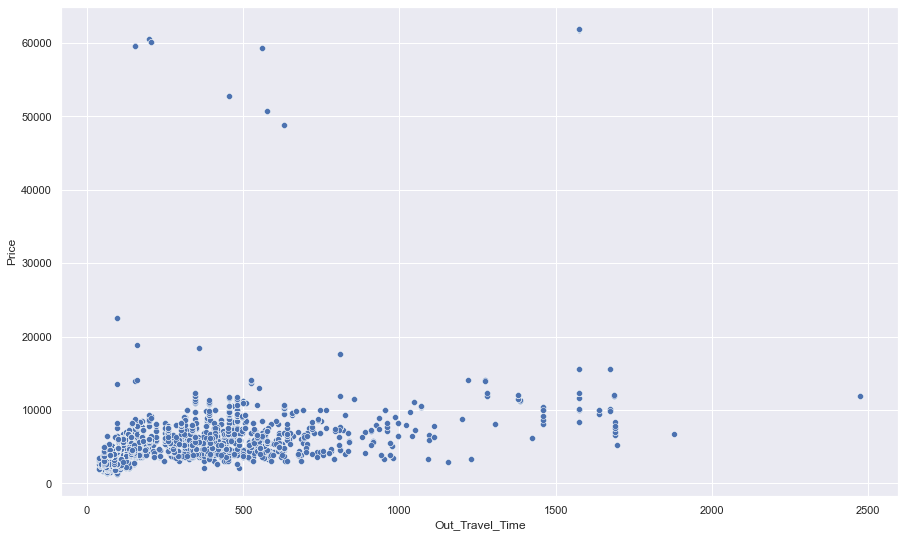

In [68]:
plt.figure(figsize=(15,9))
sns.scatterplot(data=df, x='Out_Travel_Time', y='Price')

<AxesSubplot:xlabel='Out_Month'>

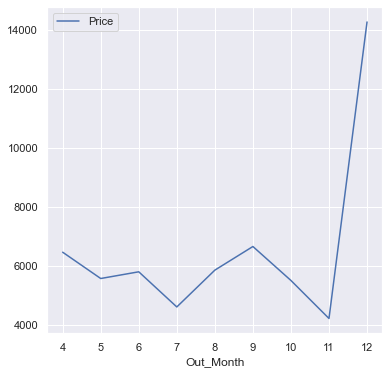

In [69]:
monthly_avg=df.groupby(['Out_Month']).agg({'Price':np.mean}).reset_index()
monthly_avg.plot(x='Out_Month',y='Price',figsize=(6,6))

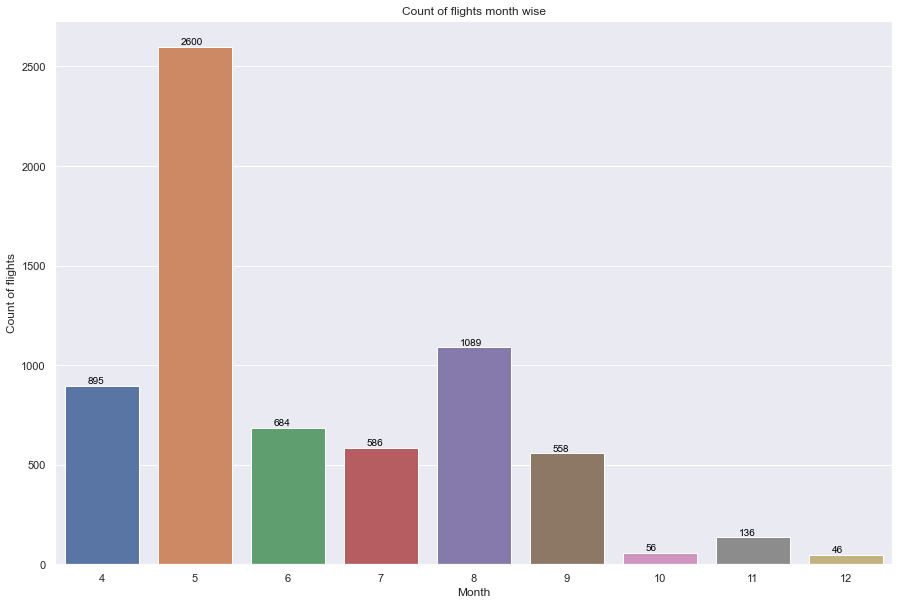

In [70]:
# Count of flights month wise :

plt.figure(figsize = (15, 10))
plt.title('Count of flights month wise')
ax=sns.countplot(x = 'Out_Month', data = df)
plt.xlabel('Month')
plt.ylabel('Count of flights')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

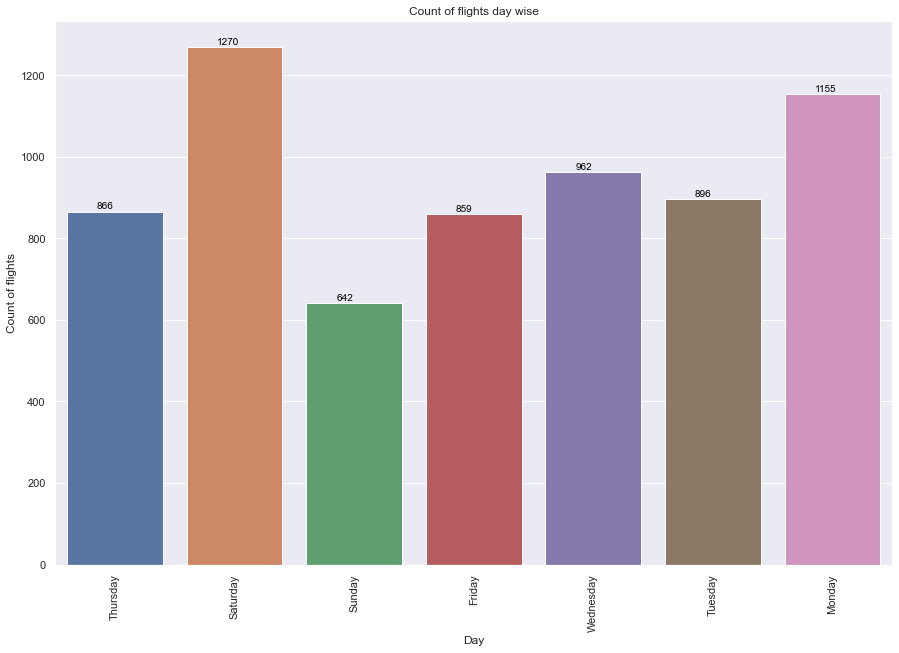

In [71]:
# Count of flights day wise :

plt.figure(figsize = (15, 10))
plt.title('Count of flights day wise')
ax=sns.countplot(x = 'Out_Weekday', data =df)
plt.xlabel('Day')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

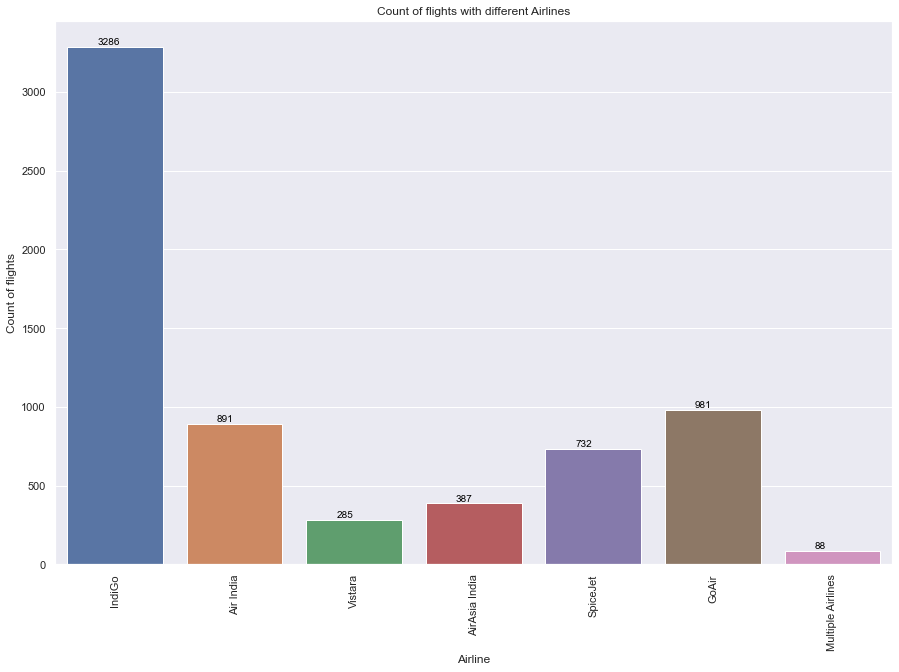

In [72]:
# Count of flights with different Airlines :

plt.figure(figsize = (15, 10))
plt.title('Count of flights with different Airlines')
ax=sns.countplot(x = 'Out_Airline', data =df)
plt.xlabel('Airline')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

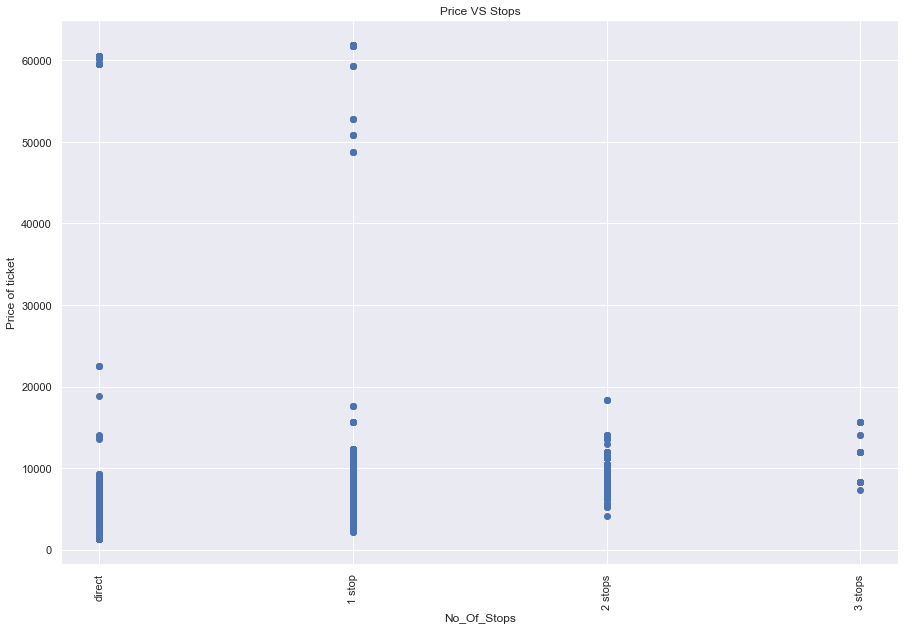

In [73]:
# Price VS Stops

plt.figure(figsize = (15, 10))
plt.title('Price VS Stops')
plt.scatter(df['Out_Journey_Type'], df['Price'])
plt.xticks(rotation = 90)
plt.xlabel('No_Of_Stops')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='Out_Journey_Type', ylabel='count'>

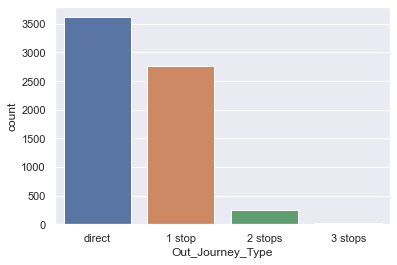

In [74]:
sns.countplot(df["Out_Journey_Type"])

<AxesSubplot:xlabel='Out_Airline', ylabel='count'>

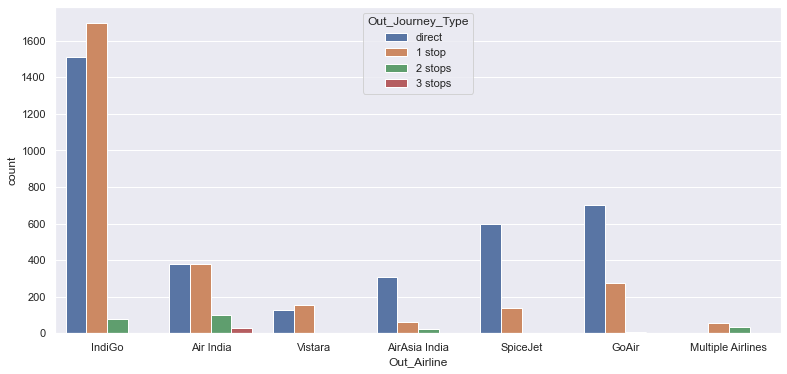

In [75]:
plt.figure(figsize = (13,6))
sns.countplot(x= "Out_Airline" , hue = "Out_Journey_Type", data= df)
#we can observe direct journey_type are higher than 1 stop journey

<AxesSubplot:title={'center':'airline with Price'}, xlabel='Out_Airline'>

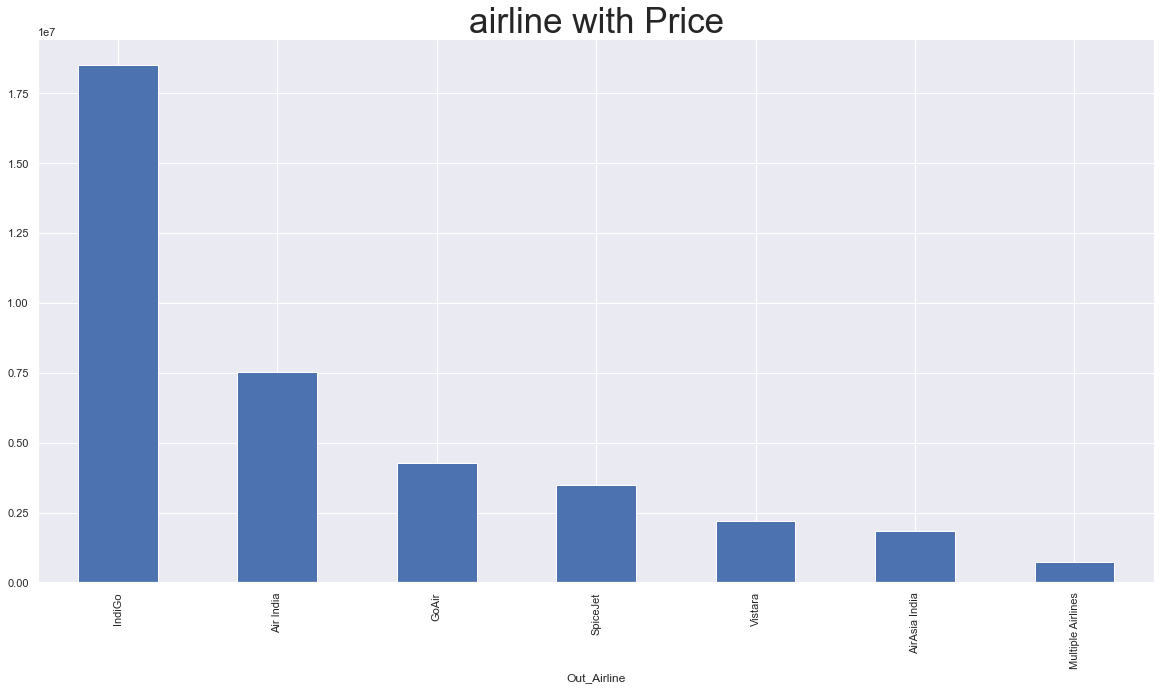

In [76]:
airline_price = df.groupby('Out_Airline')['Price'].sum()
airline_price.sort_values(ascending = False, inplace = True)
fig, ax=plt.subplots(figsize=(20,10))
plt.title('airline with Price',fontsize=35)
airline_price.plot.bar()

<AxesSubplot:title={'center':'airline with out_weekday'}, xlabel='Out_Weekday'>

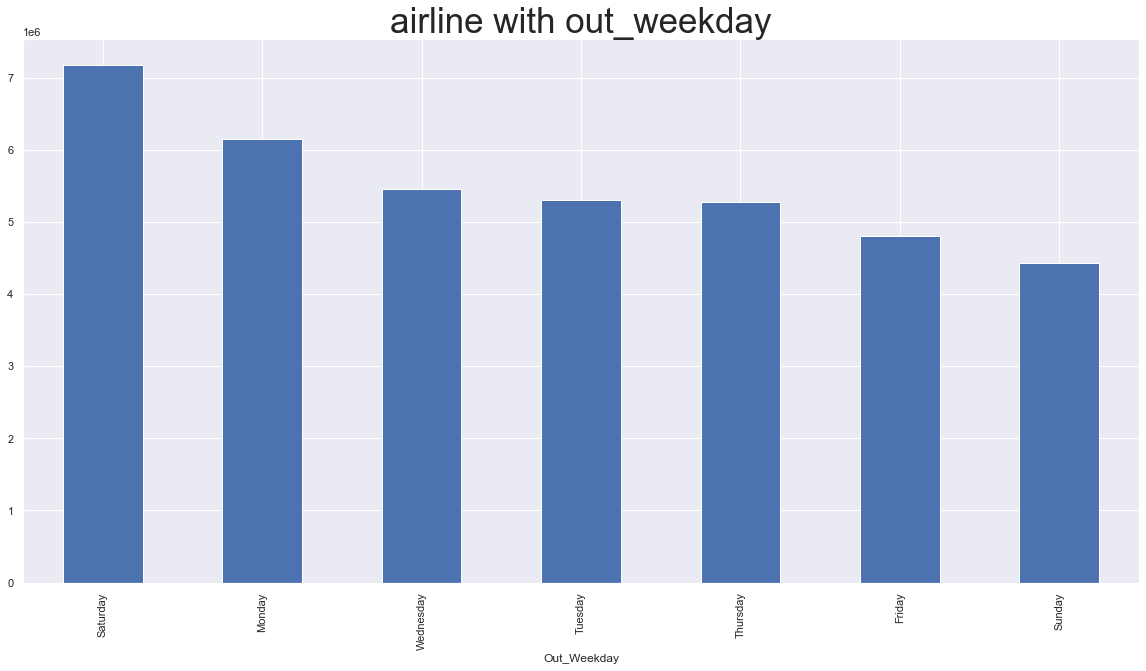

In [77]:
airline_price = df.groupby('Out_Weekday')['Price'].sum()
airline_price.sort_values(ascending = False, inplace = True)
fig, ax=plt.subplots(figsize=(20,10))
plt.title('airline with out_weekday',fontsize=35)
airline_price.plot.bar()

<AxesSubplot:xlabel='Out_Airline', ylabel='count'>

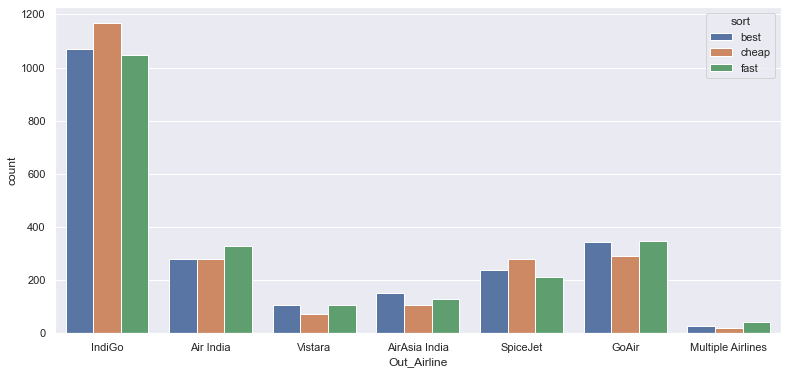

In [78]:
plt.figure(figsize = (13,6))
sns.countplot(x= "Out_Airline" , hue = "sort", data= df)

<AxesSubplot:title={'center':'Price variation with Out_Month'}, xlabel='Out_Month'>

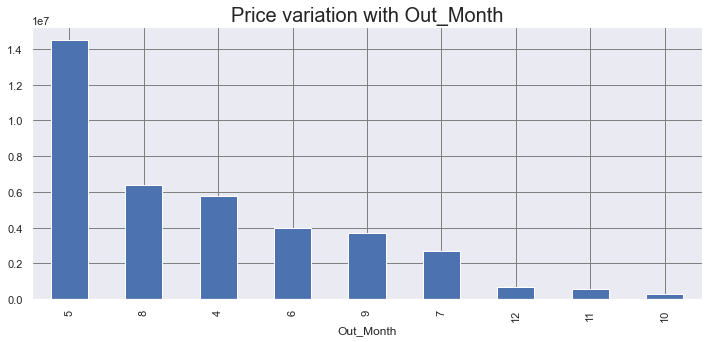

In [79]:
month_price = df.groupby('Out_Month')['Price'].sum()
month_price.sort_values(ascending = False, inplace = True)
fig, ax=plt.subplots(figsize=(12,5))
plt.grid(True, color='grey')
plt.title('Price variation with Out_Month',fontsize=20)
month_price.plot.bar()

<AxesSubplot:xlabel='Out_Weekday'>

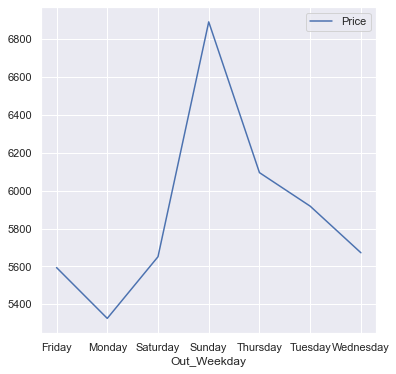

In [80]:
monthly_avg=df.groupby(['Out_Weekday']).agg({'Price':np.mean}).reset_index()
monthly_avg.plot(x='Out_Weekday',y='Price',figsize=(6,6))

**Handling Categorical Data**

One can find many ways to handle categorical data. Some of them categorical data are,

**Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case
**Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

In [81]:
df['Out_Airline'].value_counts()

IndiGo               3286
GoAir                 981
Air India             891
SpiceJet              732
AirAsia India         387
Vistara               285
Multiple Airlines      88
Name: Out_Airline, dtype: int64

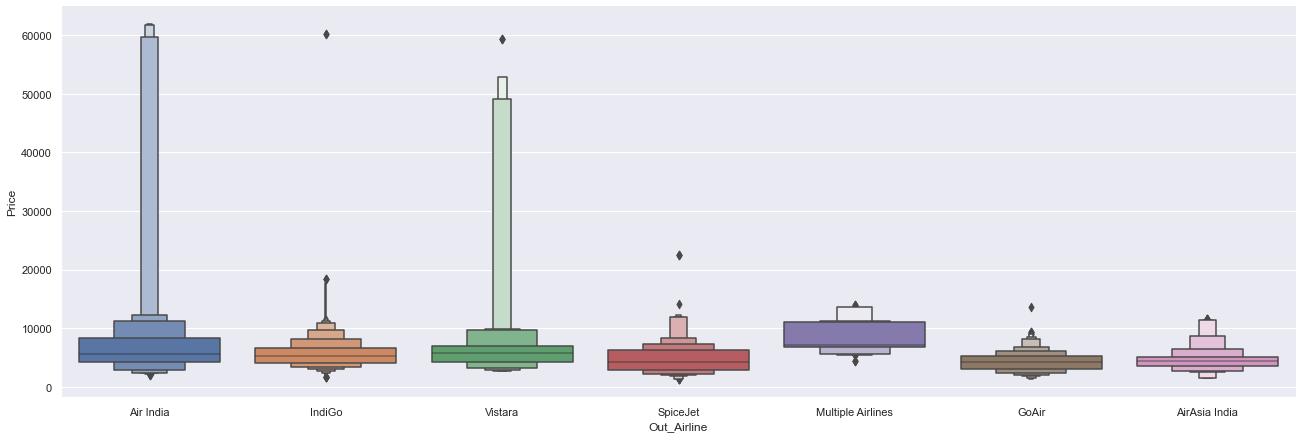

In [82]:
# Out_Airline vs Price
sns.catplot(y = "Price", x = "Out_Airline", data = df.sort_values("Price", ascending = False), 
            kind="boxen", height = 6, aspect = 3)
plt.show()

In [83]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding

Out_Airline = df[["Out_Airline"]]

Out_Airline = pd.get_dummies(Out_Airline)

Out_Airline.head()

Out_Airline_Air India  Out_Airline_AirAsia India  Out_Airline_GoAir  \
0                      0                          0                  0   
1                      1                          0                  0   
2                      0                          0                  0   
3                      0                          0                  0   
4                      0                          0                  0   

   Out_Airline_IndiGo  Out_Airline_Multiple Airlines  Out_Airline_SpiceJet  \
0                   1                              0                     0   
1                   0                              0                     0   
2                   1                              0                     0   
3                   1                              0                     0   
4                   1                              0                     0   

   Out_Airline_Vistara  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [84]:
df['Out_Cities'].value_counts()

CCU Netaji                541
BLR Bengaluru             433
DEL Indira                381
JAI Sanganeer             366
BBI Bhubaneswar           285
GAU Borjhar               262
MAA Chennai               225
NAG Dr.                   212
BOM Chhatrapati           210
TRV Thiruvananthapuram    194
PAT Patna                 190
PNQ Lohegaon              186
LKO Amausi                182
BDQ Vadodara              178
SHL Shillong              167
HYD Rajiv                 133
IXC Chandigarh            123
CNN Kannur                120
+1 MAA                    117
IXR Ranchi                114
GOI Dabolim               114
SXR Srinagar              101
CCJ Kozhikode             100
DED Dehra                  90
ATQ Sri                    89
VNS Varanasi               78
+1 CCU                     75
+1 NAG                     64
IXM Madurai                64
IDR Indore                 63
+1 TRV                     62
+1 VTZ                     58
+1 GAU                     57
RPR Raipur

In [85]:
# Consider only the code of the place and removing the rest like the name or the +1 in the beginning.
c = list(df["Out_Cities"])
cities = []
for i in range(len(c)):
    if len(c[i].split()) == 2:
        if '+1' in c[i]:
            cities.append(c[i].split()[1])
        elif '+2' in c[i]:
            cities.append(c[i].split()[1])   
        else:
            cities.append(c[i].split()[0])

In [86]:
df["Out_Cities"] = cities

In [87]:
df['Return_Cities'].value_counts()

DEL Indira                632
CCU Netaji                429
HYD Rajiv                 386
BOM Chhatrapati           382
BLR Bengaluru             332
MAA Chennai               285
TRV Thiruvananthapuram    198
GAU Borjhar               180
AMD Ahmedabad             179
ATQ Sri                   170
STV Surat                 157
CJB Peelamedu             141
KNU Kanpur                137
NAG Dr.                   133
GOI Dabolim               130
UDR Dabok                 127
+1 AMD                    120
JAI Sanganeer             114
VNS Varanasi              105
PAT Patna                 101
IXE Bajpe                  93
SXR Srinagar               93
IXC Chandigarh             89
IDR Indore                 87
AGX Agatti                 85
PNQ Lohegaon               83
TRZ Civil                  79
BHO Bhopal                 78
HBX Hubballi               76
GOP Gorakhpur              76
LKO Amausi                 64
+1 CJB                     54
+1 PAT                     49
+1 RAJ    

In [88]:
# Doing the same for the return cities.
c = list(df["Return_Cities"])
cities = []
for i in range(len(c)):
    if len(c[i].split()) == 2:
        if '+1' in c[i]:
            cities.append(c[i].split()[1])
        elif '+2' in c[i]:
            cities.append(c[i].split()[1])
        else: 
            cities.append(c[i].split()[0])

In [89]:
df["Return_Cities"] = cities

In [90]:
# As the returning cities are our destination so are changing the name to 'Dest_Cities'.

df['Return_Cities'] = df.rename(columns = {'Return_Cities':'Dest_Cities'},inplace=True)

In [91]:
df.head()

Out_Day Out_Weekday  Out_Month Out_Cities Out_Airline  Return_Day  \
0        6    Thursday          5        IXM      IndiGo          26   
1        6    Thursday          5        GOI   Air India          26   
2        6    Thursday          5        IXM      IndiGo          26   
3        6    Thursday          5        IXM      IndiGo          26   
4        6    Thursday          5        IXM      IndiGo          26   

  Return_Weekday Dest_Cities Return_Airline  Out_Travel_Time Out_Journey_Type  \
0      Wednesday         BLR         IndiGo               80           direct   
1      Wednesday         BLR      Air India             1155           1 stop   
2      Wednesday         BLR         IndiGo               80           direct   
3      Wednesday         BLR         IndiGo               80           direct   
4      Wednesday         BLR         IndiGo               80           direct   

  Return_Journey_Type    Price           timestamp  sort  Target_Var  \
0              1 stop  3495.52 2021-04-16 00:38:00  best       30072   
1              1 stop  2856.00 2021-04-16 00:38:00  best       29917   
2              direct  3357.20 2021-04-16 00:38:00  best       29267   
3              direct  3357.20 2021-04-16 00:38:00  best       30072   
4              direct  3357.20 2021-04-16 00:38:00  best       29267   

   Out_hour  Out_min Return_Cities  
0        21       50          None  
1        19       15          None  
2         8       25          None  
3        21       50          None  
4         8       25          None

In [92]:
df.drop(["Return_Cities"], axis=1, inplace=True)

In [93]:
df['Out_Cities'].unique()

array(['IXM', 'GOI', 'AMD', 'ATQ', 'BLR', 'BBI', 'BDQ', 'BHO', 'BKB',
       'BOM', 'CCJ', 'CCU', 'IXC', 'MAA', 'CJB', 'DED', 'DEL', 'GAU',
       'GAY', 'HBX', 'HYD', 'IDR', 'IMF', 'ISK', 'IXL', 'SXR', 'IXR',
       'JAI', 'CNN', 'LKO', 'IXE', 'NAG', 'PAT', 'PNQ', 'RPR', 'SHL',
       'STV', 'TRV', 'VNS', 'VGA', 'VTZ'], dtype=object)

In [94]:
df['Dest_Cities'].unique()

array(['BLR', 'MAA', 'BOM', 'TRV', 'STV', 'VNS', 'HYD', 'KNU', 'ATQ',
       'DEL', 'CJB', 'AMD', 'BHO', 'GOI', 'UDR', 'COK', 'GAU', 'IXA',
       'IXB', 'IXZ', 'JLR', 'AGX', 'CCU', 'GOP', 'IXL', 'CCJ', 'NAG',
       'PNQ', 'RAJ', 'DIB', 'GAY', 'IMF', 'SXR', 'LKO', 'JAI', 'HBX',
       'IXE', 'PAT', 'IXC', 'IXR', 'VGA', 'DED', 'IDR', 'TRZ', 'BDQ',
       'JDH', 'DIU', 'IXU', 'SHL'], dtype=object)

In [95]:
df['Out_Cities'].value_counts()

CCU    616
BLR    475
DEL    417
JAI    396
MAA    345
BBI    322
GAU    319
NAG    276
TRV    256
PAT    242
BOM    231
PNQ    193
BDQ    186
LKO    184
SHL    167
IXC    143
HYD    139
CNN    135
GOI    123
IXR    115
CCJ    106
SXR    106
VTZ     96
VNS     94
IXM     94
ATQ     93
RPR     92
DED     90
IDR     73
BHO     51
IMF     50
CJB     49
GAY     48
AMD     47
VGA     46
ISK     46
HBX     45
IXL     45
BKB     45
IXE     45
STV      9
Name: Out_Cities, dtype: int64

In [96]:
df.shape

(6650, 18)

In [97]:
df['Out_Cities'].unique()

array(['IXM', 'GOI', 'AMD', 'ATQ', 'BLR', 'BBI', 'BDQ', 'BHO', 'BKB',
       'BOM', 'CCJ', 'CCU', 'IXC', 'MAA', 'CJB', 'DED', 'DEL', 'GAU',
       'GAY', 'HBX', 'HYD', 'IDR', 'IMF', 'ISK', 'IXL', 'SXR', 'IXR',
       'JAI', 'CNN', 'LKO', 'IXE', 'NAG', 'PAT', 'PNQ', 'RPR', 'SHL',
       'STV', 'TRV', 'VNS', 'VGA', 'VTZ'], dtype=object)

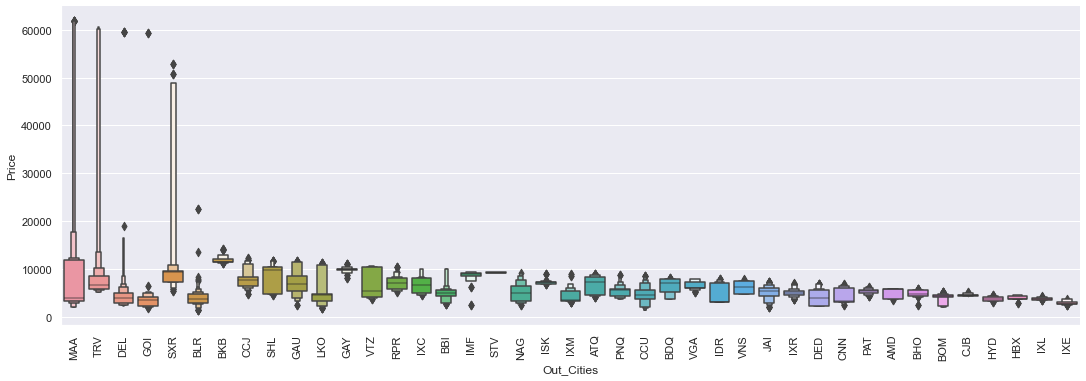

In [98]:
sns.catplot(y = "Price", x = "Out_Cities", data = df.sort_values("Price", ascending = False), kind="boxen", height = 5, aspect = 3)
plt.xticks(rotation=90)
plt.show()

In [99]:
Out_Cities = df[["Out_Cities"]]

Out_Cities = pd.get_dummies(Out_Cities)

Out_Cities.head()

Out_Cities_AMD  Out_Cities_ATQ  Out_Cities_BBI  Out_Cities_BDQ  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_BHO  Out_Cities_BKB  Out_Cities_BLR  Out_Cities_BOM  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_CCJ  Out_Cities_CCU  Out_Cities_CJB  Out_Cities_CNN  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_DED  Out_Cities_DEL  Out_Cities_GAU  Out_Cities_GAY  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_GOI  Out_Cities_HBX  Out_Cities_HYD  Out_Cities_IDR  \
0               0               0               0               0   
1               1               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IMF  Out_Cities_ISK  Out_Cities_IXC  Out_Cities_IXE  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IXL  Out_Cities_IXM  Out_Cities_IXR  Out_Cities_JAI  \
0               0               1               0               0   
1               0               0               0               0   
2               0               1               0               0   
3               0               1               0               0   
4               0               1               0               0   

   Out_Cities_LKO  Out_Cities_MAA  Out_Cities_NAG  Out_Cities_PAT  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_PNQ  Out_Cities_RPR  Out_Cities_SHL  Out_Cities_STV  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_SXR  Out_Cities_TRV  Out_Cities_VGA  Out_Cities_VNS  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0            

In [100]:
Dest_Cities = df[["Dest_Cities"]]

Dest_Cities = pd.get_dummies(Dest_Cities)

Dest_Cities.head()

Dest_Cities_AGX  Dest_Cities_AMD  Dest_Cities_ATQ  Dest_Cities_BDQ  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_BHO  Dest_Cities_BLR  Dest_Cities_BOM  Dest_Cities_CCJ  \
0                0                1                0                0   
1                0                1                0                0   
2                0                1                0                0   
3                0                1                0                0   
4                0                1                0                0   

   Dest_Cities_CCU  Dest_Cities_CJB  Dest_Cities_COK  Dest_Cities_DED  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_DEL  Dest_Cities_DIB  Dest_Cities_DIU  Dest_Cities_GAU  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_GAY  Dest_Cities_GOI  Dest_Cities_GOP  Dest_Cities_HBX  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_HYD  Dest_Cities_IDR  Dest_Cities_IMF  Dest_Cities_IXA  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_IXB  Dest_Cities_IXC  Dest_Cities_IXE  Dest_Cities_IXL  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_IXR  Dest_Cities_IXU  Dest_Cities_IXZ  Dest_Cities_JAI  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_JDH  Dest_Cities_JLR  Dest_Cities_KNU  Dest_Cities_LKO  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Dest_Cities_MAA  Dest_Cities_NAG  Dest_Cities_PAT

In [101]:
df['Out_Journey_Type'].value_counts()

direct     3618
1 stop     2762
2 stops     242
3 stops      28
Name: Out_Journey_Type, dtype: int64

In [102]:
df['Out_Journey_Type'].replace({"direct": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3}, inplace = True)

In [103]:
df['Out_Journey_Type'].head()

0    0
1    1
2    0
3    0
4    0
Name: Out_Journey_Type, dtype: int64

In [104]:
df['sort'].replace({"cheap": 0, "best": 1, "fast": 2}, inplace = True)


In [105]:
df.drop(['Out_Cities','Out_Airline','Return_Airline'], axis=1, inplace=True)

In [106]:
df.drop(['Return_Day','Return_Weekday','Return_Journey_Type'], axis=1, inplace=True)


In [107]:
df['Out_Weekday'].value_counts()

Saturday     1270
Monday       1155
Wednesday     962
Tuesday       896
Thursday      866
Friday        859
Sunday        642
Name: Out_Weekday, dtype: int64

In [108]:
df['Out_Weekday'].replace({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6}, inplace = True)

In [109]:
data = pd.concat([df, Out_Cities, Out_Airline, Dest_Cities], axis=1)

In [110]:
data.head()

Out_Day  Out_Weekday  Out_Month Dest_Cities  Out_Travel_Time  \
0        6            3          5         BLR               80   
1        6            3          5         BLR             1155   
2        6            3          5         BLR               80   
3        6            3          5         BLR               80   
4        6            3          5         BLR               80   

   Out_Journey_Type    Price           timestamp  sort  Target_Var  Out_hour  \
0                 0  3495.52 2021-04-16 00:38:00     1       30072        21   
1                 1  2856.00 2021-04-16 00:38:00     1       29917        19   
2                 0  3357.20 2021-04-16 00:38:00     1       29267         8   
3                 0  3357.20 2021-04-16 00:38:00     1       30072        21   
4                 0  3357.20 2021-04-16 00:38:00     1       29267         8   

   Out_min  Out_Cities_AMD  Out_Cities_ATQ  Out_Cities_BBI  Out_Cities_BDQ  \
0       50               0               0               0               0   
1       15               0               0               0               0   
2       25               0               0               0               0   
3       50               0               0               0               0   
4       25               0               0               0               0   

   Out_Cities_BHO  Out_Cities_BKB  Out_Cities_BLR  Out_Cities_BOM  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_CCJ  Out_Cities_CCU  Out_Cities_CJB  Out_Cities_CNN  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_DED  Out_Cities_DEL  Out_Cities_GAU  Out_Cities_GAY  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_GOI  Out_Cities_HBX  Out_Cities_HYD  Out_Cities_IDR  \
0               0               0               0               0   
1               1               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IMF  Out_Cities_ISK  Out_Cities_IXC  Out_Cities_IXE  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IXL  Out_Cities_IXM  Out_Cities_IXR  Out_Cities_JAI  \
0               0               1               0               0   
1               0               0               0               0   
2               0               1               0               0   
3               0               1               0               0   
4               0               1               0               0   

   Out_Cities_LKO  Out_Cities_MAA  Out_Cities_NAG  Out_Cities_PAT  \
0               0               0               0               0   
1               0     

In [111]:
data.shape

(6650, 109)

In [112]:
data.columns

Index(['Out_Day', 'Out_Weekday', 'Out_Month', 'Dest_Cities', 'Out_Travel_Time',
       'Out_Journey_Type', 'Price', 'timestamp', 'sort', 'Target_Var',
       ...
       'Dest_Cities_PNQ', 'Dest_Cities_RAJ', 'Dest_Cities_SHL',
       'Dest_Cities_STV', 'Dest_Cities_SXR', 'Dest_Cities_TRV',
       'Dest_Cities_TRZ', 'Dest_Cities_UDR', 'Dest_Cities_VGA',
       'Dest_Cities_VNS'],
      dtype='object', length=109)

In [113]:
data.drop(['timestamp','Dest_Cities'], axis=1, inplace=True)

In [114]:
data.columns

Index(['Out_Day', 'Out_Weekday', 'Out_Month', 'Out_Travel_Time',
       'Out_Journey_Type', 'Price', 'sort', 'Target_Var', 'Out_hour',
       'Out_min',
       ...
       'Dest_Cities_PNQ', 'Dest_Cities_RAJ', 'Dest_Cities_SHL',
       'Dest_Cities_STV', 'Dest_Cities_SXR', 'Dest_Cities_TRV',
       'Dest_Cities_TRZ', 'Dest_Cities_UDR', 'Dest_Cities_VGA',
       'Dest_Cities_VNS'],
      dtype='object', length=107)

### d) Feature Selection

In [115]:
data.loc[4156,'Target_Var']

64473

In [116]:
data.loc[4155:4160,'Target_Var']

4155    65178
4156    64473
4157    65178
4158    65178
4159    64568
4160    64223
Name: Target_Var, dtype: int64

In [117]:
data.loc[4155:4160,:]

Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
4155        1            1          6               65                 0   
4156        1            1          6               60                 0   
4157        1            1          6               65                 0   
4158        1            1          6               65                 0   
4159        1            1          6               60                 0   
4160        1            1          6               55                 0   

        Price  sort  Target_Var  Out_hour  Out_min  Out_Cities_AMD  \
4155  3773.84     0       65178        19       35               0   
4156  4220.16     0       64473         7       50               0   
4157  4269.44     0       65178        19       35               0   
4158  4318.16     0       65178        19       35               0   
4159  2217.60     2       64568         9       30               0   
4160  2774.80     2       64223         3       45               0   

      Out_Cities_ATQ  Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0               0               0               0   

      Out_Cities_BKB  Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0               0               0               0   

      Out_Cities_CCU  Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0               0               0               0   

      Out_Cities_DEL  Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0               0               0               0   

      Out_Cities_HBX  Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0               0               0               0   

      Out_Cities_ISK  Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  \
4155               0               0               0               0   
4156               0               0               0               0   
4157               0               0               0               0   
4158               0               0               0               0   
4159               0               0               0               0   
4160               0     

<AxesSubplot:xlabel='sort', ylabel='Price'>

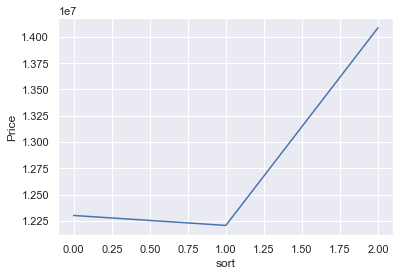

In [118]:
data_price = data.groupby('sort')['Price'].sum()
sns.lineplot(data = data_price)

In [119]:
data.dtypes.tail()

Dest_Cities_TRV    uint8
Dest_Cities_TRZ    uint8
Dest_Cities_UDR    uint8
Dest_Cities_VGA    uint8
Dest_Cities_VNS    uint8
dtype: object

In [120]:
data.head()

Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
0        6            3          5               80                 0   
1        6            3          5             1155                 1   
2        6            3          5               80                 0   
3        6            3          5               80                 0   
4        6            3          5               80                 0   

     Price  sort  Target_Var  Out_hour  Out_min  Out_Cities_AMD  \
0  3495.52     1       30072        21       50               0   
1  2856.00     1       29917        19       15               0   
2  3357.20     1       29267         8       25               0   
3  3357.20     1       30072        21       50               0   
4  3357.20     1       29267         8       25               0   

   Out_Cities_ATQ  Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_BKB  Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_CCU  Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_DEL  Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  \
0               0               0               0               0   
1               0               0               0               1   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_HBX  Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_ISK  Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IXM  Out_Cities_IXR  Out_Cities_JAI  Out_Cities_LKO  \
0               1               0               0               0   
1               0               0               0               0   
2               1               0               0               0   
3               1               0               0               0   
4               1               0               0               0   

   Out_Cities_MAA  Out_Cities_NAG  Out_Cities_PAT  Out_Cities_PNQ  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0

In [121]:
x = data.copy()
y = x.pop('Target_Var')

In [122]:
x.head()

Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
0        6            3          5               80                 0   
1        6            3          5             1155                 1   
2        6            3          5               80                 0   
3        6            3          5               80                 0   
4        6            3          5               80                 0   

     Price  sort  Out_hour  Out_min  Out_Cities_AMD  Out_Cities_ATQ  \
0  3495.52     1        21       50               0               0   
1  2856.00     1        19       15               0               0   
2  3357.20     1         8       25               0               0   
3  3357.20     1        21       50               0               0   
4  3357.20     1         8       25               0               0   

   Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  Out_Cities_BKB  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  Out_Cities_CCU  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  Out_Cities_DEL  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  Out_Cities_HBX  \
0               0               0               0               0   
1               0               0               1               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  Out_Cities_ISK  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  Out_Cities_IXM  \
0               0               0               0               1   
1               0               0               0               0   
2               0               0               0               1   
3               0               0               0               1   
4               0               0               0               1   

   Out_Cities_IXR  Out_Cities_JAI  Out_Cities_LKO  Out_Cities_MAA  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   Out_Cities_NAG  Out_Cities_PAT  Out_Cities_PNQ  Out_Cities_RPR  \
0               0               0               0               0   
1               0               0               0               0   
2               0        

In [123]:
discrete_features = x.dtypes == int

In [124]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(x, y, discrete_features):
    mi_scores = mutual_info_regression(x, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(x, y, discrete_features)
mi_scores[:10]

Price                 3.633842
Out_Travel_Time       3.451180
Out_Day               3.038914
Out_hour              2.343882
Out_min               1.880188
Out_Weekday           1.732282
Out_Month             1.729427
Out_Journey_Type      0.648962
Out_Airline_IndiGo    0.533088
sort                  0.484708
Name: MI Scores, dtype: float64

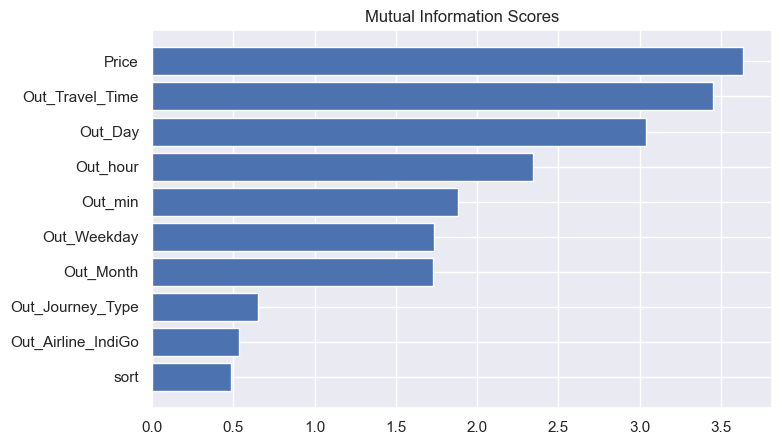

In [125]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:10])

So, it comes out to be that the 'Price','Out_Day', 'Out_Weekday','Out_hour' and 'Out_Month' have a very good MI scores which means they hiave a very strong relationship with the target variable. 'Out_Month' and 'Out_min' and 'Price also plays a very important role. 

Checking the top features

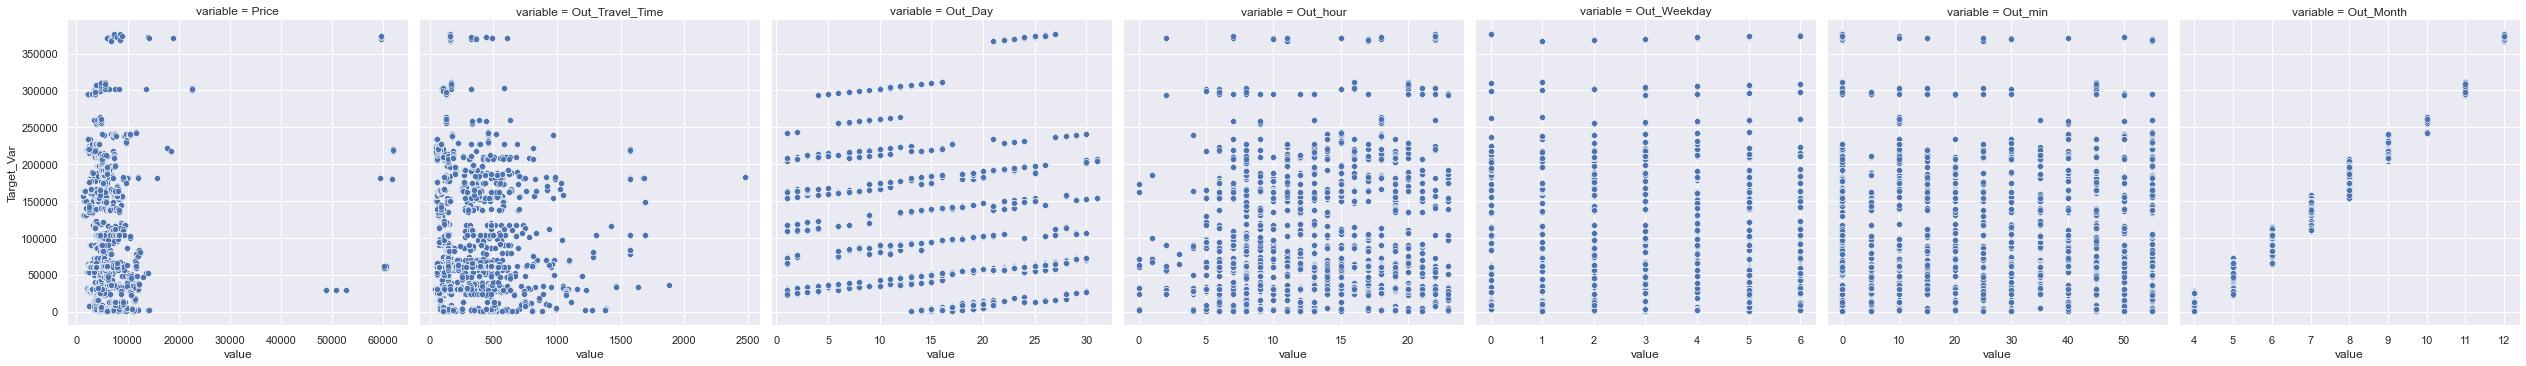

In [126]:
features = ["Price","Out_Travel_Time", "Out_Day", "Out_hour","Out_Weekday","Out_min","Out_Month"]
sns.relplot(
    x="value", y="Target_Var", col="variable", data=df.melt(id_vars="Target_Var", 
                                                            value_vars=features), facet_kws=dict(sharex=False),
);

In [127]:
data1 = data[['Target_Var','Price','Out_Day','Out_Month','Out_Travel_Time','Out_Weekday','Out_hour','Out_Journey_Type',
             'Out_min','Out_Airline_IndiGo']]
corr = data1.corr()
corr

Target_Var     Price   Out_Day  Out_Month  \
Target_Var            1.000000  0.028590 -0.041535   0.985692   
Price                 0.028590  1.000000  0.073066   0.023924   
Out_Day              -0.041535  0.073066  1.000000  -0.203945   
Out_Month             0.985692  0.023924 -0.203945   1.000000   
Out_Travel_Time      -0.016988  0.407222  0.048595  -0.010307   
Out_Weekday           0.030167  0.046304 -0.211524   0.064551   
Out_hour              0.044792 -0.024159  0.033462   0.034053   
Out_Journey_Type     -0.009109  0.289033  0.060765  -0.003644   
Out_min              -0.005219 -0.042398  0.099416  -0.019024   
Out_Airline_IndiGo   -0.112534 -0.032414  0.052969  -0.117890   

                    Out_Travel_Time  Out_Weekday  Out_hour  Out_Journey_Type  \
Target_Var                -0.016988     0.030167  0.044792         -0.009109   
Price                      0.407222     0.046304 -0.024159          0.289033   
Out_Day                    0.048595    -0.211524  0.033462          0.060765   
Out_Month                 -0.010307     0.064551  0.034053         -0.003644   
Out_Travel_Time            1.000000     0.137795 -0.017982          0.772930   
Out_Weekday                0.137795     1.000000  0.011460          0.068095   
Out_hour                  -0.017982     0.011460  1.000000         -0.112373   
Out_Journey_Type           0.772930     0.068095 -0.112373          1.000000   
Out_min                   -0.020174    -0.039912  0.023807          0.020929   
Out_Airline_IndiGo        -0.070936    -0.053185  0.006831          0.106313   

                     Out_min  Out_Airline_IndiGo  
Target_Var         -0.005219           -0.112534  
Price              -0.042398           -0.032414  
Out_Day             0.099416            0.052969  
Out_Month          -0.019024           -0.117890  
Out_Travel_Time    -0.020174           -0.070936  
Out_Weekday        -0.039912           -0.053185  
Out_hour            0.023807            0.006831  
Out_Journey_Type    0.020929            0.106313  
Out_min             1.000000            0.071393  
Out_Airline_IndiGo  0.071393            1.000000

<AxesSubplot:>

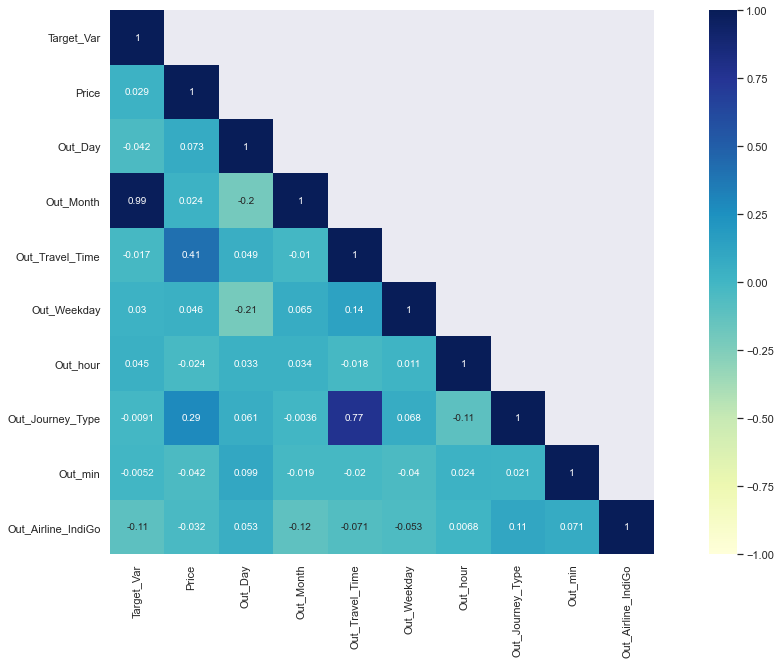

In [128]:
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, square=True,annot=True, cmap="YlGnBu")

In [129]:
data1 = data.copy()
data1["AvgPrice"] = (
    data.groupby("sort")  # for each state
    ["Price"]                 # select the income
    .transform("mean")         # and compute its mean
)

data1[["sort", "Price", "AvgPrice"]].head(10)

sort    Price     AvgPrice
0     1  3495.52  5508.230758
1     1  2856.00  5508.230758
2     1  3357.20  5508.230758
3     1  3357.20  5508.230758
4     1  3357.20  5508.230758
5     1  3357.20  5508.230758
6     1  3357.20  5508.230758
7     1  3357.20  5508.230758
8     1  3449.04  5508.230758
9     1  3531.36  5508.230758

In [130]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

### e) PCA

#### Train Test Split

In [131]:
# Putting feature variables to X
X = data.copy()

# Putting response variable to y
y = X.pop('Target_Var')

In [132]:
print("Size of Feature variables dataset is:",X.shape)
print("Size of response variable dataset is:",y.shape)

Size of Feature variables dataset is: (6650, 106)
Size of response variable dataset is: (6650,)


In [133]:
# Let us split our dataset into train & yest
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 , random_state=100)

In [134]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4655, 106), (1995, 106), (4655,), (1995,))

#### Feature scaling

In [135]:
print("Glimpse of Feature variables in train dataset - x_train:")
X_train.head()

Glimpse of Feature variables in train dataset - x_train:


Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
1934        2            4          7              130                 0   
1012       28            2          4              150                 0   
1119       15            6          8              120                 0   
6178       10            1          8              430                 1   
6222       21            4          5              200                 0   

        Price  sort  Out_hour  Out_min  Out_Cities_AMD  Out_Cities_ATQ  \
1934  4679.36     2         8       20               0               0   
1012  3656.24     2        23        0               0               0   
1119  4338.32     0        17       10               0               0   
6178  5162.08     2        23       30               0               0   
6222  9320.64     1        13       20               0               0   

      Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  Out_Cities_BKB  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  Out_Cities_CCU  \
1934               0               0               0               1   
1012               1               0               0               0   
1119               1               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  Out_Cities_DEL  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  Out_Cities_HBX  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  Out_Cities_ISK  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  Out_Cities_IXM  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXR  Out_Cities_JAI  Out_Cities_LKO  Out_Cities_MAA  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_NAG  Out_Cities_PAT  Out_Cities_PNQ  Out_Cities_RPR  \
1

In [136]:
num_col = ['Out_Day', 'Out_Weekday', 'Out_Month', 'Out_Travel_Time',
       'Out_Journey_Type', 'Price','sort', 'Out_hour', 'Out_min']
len(num_col)

9

In [137]:

# Import the StandardScaler()
from sklearn.preprocessing import StandardScaler

## Scaling the train and test data
sc = StandardScaler()
X_train[num_col] = sc.fit_transform(X_train[num_col])
X_test[num_col] = sc.transform(X_test[num_col])
X_train.head()

Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
1934 -1.370841     0.566487   0.452902        -0.562710         -0.835273   
1012  1.454363    -0.433133  -1.198475        -0.496274         -0.835273   
1119  0.041761     1.566107   1.003361        -0.595928         -0.835273   
6178 -0.501548    -0.932943   1.003361         0.433834          0.882887   
6222  0.693731     0.566487  -0.648016        -0.330183         -0.835273   

         Price      sort  Out_hour   Out_min  Out_Cities_AMD  Out_Cities_ATQ  \
1934 -0.217404  1.222315 -0.913725 -0.389058               0               0   
1012 -0.413190  1.222315  1.886277 -1.463396               0               0   
1119 -0.282666 -1.224944  0.766276 -0.926227               0               0   
6178 -0.125030  1.222315  1.886277  0.148111               0               0   
6222  0.670758 -0.001314  0.019609 -0.389058               0               0   

      Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  Out_Cities_BKB  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  Out_Cities_CCU  \
1934               0               0               0               1   
1012               1               0               0               0   
1119               1               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  Out_Cities_DEL  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  Out_Cities_HBX  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  Out_Cities_ISK  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  Out_Cities_IXM  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXR  Out_Cities_JAI  Out_Cities_LKO  Out_Cities_MAA  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_NAG  Out_Cities

#### Applying PCA <bR>
In the exploratory data analaysis we saw that some columns have significant correlation among themselves. This collinearity can hamper our interpretations. Principal component analysis (PCA) is one of the most commonly used dimensionality reduction techniques in the industry. So let us adopt PCA to solve this problem. PCA will also help in dimensionality reduction.

In [138]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized',random_state = 42)

In [139]:
#Performing PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [140]:
# Let us observe pricipal components created
print("The Principal components are:")
pca.components_

The Principal components are:


array([[ 5.24203965e-02,  1.24467343e-01, -1.33373561e-02, ...,
         1.03840832e-02,  3.79207178e-03,  8.26166623e-03],
       [-6.51940294e-01,  4.91792477e-01,  4.79081787e-01, ...,
         1.61868610e-02,  1.33606653e-02, -7.65233386e-04],
       [ 8.02842651e-03, -1.15273352e-01, -8.16549704e-02, ...,
        -2.90987404e-04, -1.00598513e-03,  1.77011361e-03],
       ...,
       [ 0.00000000e+00,  3.29817397e-17,  3.57746576e-17, ...,
         9.04003632e-02,  9.04003632e-02,  9.04003632e-02],
       [-0.00000000e+00, -4.89884086e-17,  3.98154697e-17, ...,
        -4.00191265e-02, -4.00191265e-02, -4.00191265e-02],
       [-0.00000000e+00,  1.17729109e-17, -1.06218866e-18, ...,
        -5.63026754e-05, -5.63026754e-05, -5.63026754e-05]])

In [141]:
# Let us also look at the variance ratio
var_ratio = np.round((pca.explained_variance_ratio_) * 100,2)
var_ratio

array([1.779e+01, 1.204e+01, 9.220e+00, 8.800e+00, 8.400e+00, 7.950e+00,
       6.460e+00, 5.990e+00, 3.030e+00, 1.680e+00, 1.180e+00, 1.080e+00,
       8.800e-01, 8.000e-01, 7.100e-01, 6.400e-01, 6.000e-01, 5.800e-01,
       5.300e-01, 5.200e-01, 4.800e-01, 4.500e-01, 4.200e-01, 4.100e-01,
       4.000e-01, 3.800e-01, 3.600e-01, 3.500e-01, 3.500e-01, 3.400e-01,
       3.100e-01, 3.000e-01, 2.700e-01, 2.500e-01, 2.500e-01, 2.500e-01,
       2.400e-01, 2.200e-01, 2.100e-01, 2.000e-01, 2.000e-01, 1.900e-01,
       1.900e-01, 1.800e-01, 1.700e-01, 1.600e-01, 1.500e-01, 1.500e-01,
       1.500e-01, 1.400e-01, 1.400e-01, 1.400e-01, 1.300e-01, 1.300e-01,
       1.200e-01, 1.200e-01, 1.100e-01, 1.000e-01, 1.000e-01, 9.000e-02,
       9.000e-02, 9.000e-02, 8.000e-02, 8.000e-02, 8.000e-02, 7.000e-02,
       7.000e-02, 7.000e-02, 6.000e-02, 6.000e-02, 6.000e-02, 6.000e-02,
       6.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02, 5.000e-02,
       5.000e-02, 5.000e-02, 4.000e-02, 4.000e-02, 

In [142]:
var_cum = np.cumsum(var_ratio)
var_cum

array([ 17.79,  29.83,  39.05,  47.85,  56.25,  64.2 ,  70.66,  76.65,
        79.68,  81.36,  82.54,  83.62,  84.5 ,  85.3 ,  86.01,  86.65,
        87.25,  87.83,  88.36,  88.88,  89.36,  89.81,  90.23,  90.64,
        91.04,  91.42,  91.78,  92.13,  92.48,  92.82,  93.13,  93.43,
        93.7 ,  93.95,  94.2 ,  94.45,  94.69,  94.91,  95.12,  95.32,
        95.52,  95.71,  95.9 ,  96.08,  96.25,  96.41,  96.56,  96.71,
        96.86,  97.  ,  97.14,  97.28,  97.41,  97.54,  97.66,  97.78,
        97.89,  97.99,  98.09,  98.18,  98.27,  98.36,  98.44,  98.52,
        98.6 ,  98.67,  98.74,  98.81,  98.87,  98.93,  98.99,  99.05,
        99.11,  99.16,  99.21,  99.26,  99.31,  99.36,  99.41,  99.46,
        99.5 ,  99.54,  99.58,  99.62,  99.66,  99.7 ,  99.74,  99.78,
        99.81,  99.84,  99.87,  99.9 ,  99.92,  99.94,  99.96,  99.98,
       100.  , 100.01, 100.02, 100.03, 100.03, 100.03, 100.03, 100.03,
       100.03, 100.03])

#### Making a scree plot for the explained variance

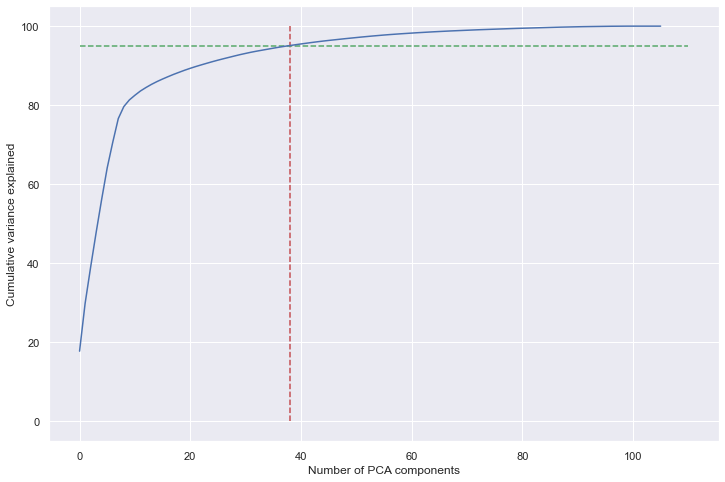

In [143]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=38, ymax=100, ymin=0, colors="r", linestyles="--")
plt.hlines(y=95, xmax=110, xmin=0, colors="g", linestyles="--")
plt.plot(var_cum)
plt.xlabel('Number of PCA components')
plt.ylabel("Cumulative variance explained")
plt.show()

<a>Looks like 38 components are enough to describe 95% of the variance in the dataset. We'll choose 38 components for our modeling

#### Adopting Incremental PCA 

Let us Build the dataframe using Incremental PCA for better efficiency.


In [144]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components = 38)

X_train_pca = pca_final.fit_transform(X_train)

In [145]:
print("Size of earlier dataset was :",X_train.shape)
print("Size of dataset after PCA is:", X_train_pca.shape)

Size of earlier dataset was : (4655, 106)
Size of dataset after PCA is: (4655, 38)


In [146]:
#creating correlation matrix for the given data
corrmat = np.corrcoef(X_train_pca.transpose())

#Make a diagonal matrix with diagonal entry of Matrix corrmat
p = np.diagflat(corrmat.diagonal())

# subtract diagonal entries making all diagonals 0
corrmat_diag_zero = corrmat - p
print("max positive corr:",round(corrmat_diag_zero.max(),3), ", min negative corr: ", round(corrmat_diag_zero.min(),3))

max positive corr: 0.004 , min negative corr:  -0.007


<a>We can see from the above calculations that the correlation among the attributes is almost 0, we can proceed with these principal components.

In [147]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(1995, 38)

In [148]:
len(X_train_pca[0])


38

In [149]:
filename = 'pca_final.sav'
pickle.dump(pca_final, open(filename, 'wb'))

In [150]:
filename = 'pca_final.sav'
xgb_model = pickle.load(open(filename, 'rb'))

## <a> 3) Model Building
Let us now build various models on this PCA Transformed dataset to predict optimal time for flight booking

In [151]:
#Creating empty DataFrame for holding models information
cols = ['Model Name','Train R2','Train MAE','Test R2','Test MAE']
model_results = pd.DataFrame(columns = cols)


### <a> Model 1- Ridge Regression

In [152]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0 ]}

ridge = Ridge(random_state=42)

# cross validation
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
ridge_model = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'neg_mean_absolute_error', 
                        cv = folds, return_train_score=True, verbose = 1)            
ridge_model.fit(X_train_pca, y_train) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [153]:
cv_results = pd.DataFrame(ridge_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.004587      0.002326         0.000602        0.000491      0.0001   
1       0.003192      0.000399         0.000798        0.000399       0.001   
2       0.003790      0.000399         0.000399        0.000489        0.01   
3       0.003191      0.000399         0.000399        0.000489        0.05   
4       0.002194      0.000399         0.000799        0.000399         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}       -2166.649328       -2141.428451       -2292.828975   
1   {'alpha': 0.001}       -2166.648655       -2141.428282       -2292.828065   
2    {'alpha': 0.01}       -2166.641917       -2141.426588       -2292.818960   
3    {'alpha': 0.05}       -2166.611985       -2141.419058       -2292.778493   
4     {'alpha': 0.1}       -2166.574593       -2141.409644       -2292.727900   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0       -2177.571410       -2139.263279     -2183.548289       56.566437   
1       -2177.570998       -2139.262690     -2183.547738       56.566252   
2       -2177.566879       -2139.256794     -2183.542228       56.564399   
3       -2177.548582       -2139.230586     -2183.517741       56.556164   
4       -2177.525725       -2139.197813     -2183.487135       56.545869   

   rank_test_score  split0_train_score  split1_train_score  \
0               20        -2175.807709        -2168.677630   
1               19        -2175.807211        -2168.677075   
2               18        -2175.802237        -2168.671524   
3               17        -2175.780196        -2168.646856   
4               16        -2175.752648        -2168.616517   

   split2_train_score  split3_train_score  split4_train_score  \
0        -2120.038665        -2164.073395        -2167.369107   
1        -2120.038406        -2164.072843        -2167.368923   
2        -2120.035815        -2164.067318        -2167.367082   
3        -2120.024299        -2164.042768        -2167.358902   
4        -2120.009900        -2164.012086        -2167.349834   

   mean_train_score  std_train_score  
0      -2159.193301        19.948612  
1      -2159.192891        19.948536  
2      -2159.188795        19.947776  
3      -2159.170604        19.944409  
4      -2159.148197        19.940348

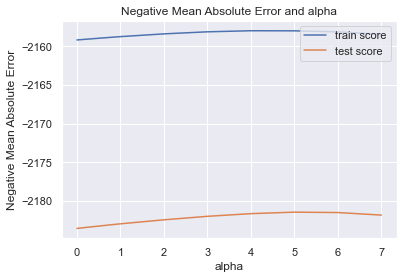

In [154]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [155]:
ridge_model.best_params_

{'alpha': 5.0}

In [156]:
ridge_model.best_score_

-2181.4453943851045

In [157]:
# model with optimal alpha
# Ridge regression
rm = Ridge(alpha=2)
rm.fit(X_train_pca, y_train)

# predict
y_train_pred = rm.predict(X_train_pca)
y_test_pred = rm.predict(X_test_pca)

print()


In [158]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)

test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [159]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  2680.246
Mean absolute error:  2162.117
Mean squared error:  7183719.975
R-squared:  0.999


In [160]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",round(mean_absolute_error(y_test.values, y_test_pred),3))
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", round(r2_score(y_test.values, y_test_pred),3))

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  2730.571
Mean absolute error:  2212.014
Mean squared error:  7456017.151
R-squared:  0.999


In [161]:
model_results.loc[-1] = ["Ridge Regression",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0  Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 2- Lasso Regression

In [162]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0 ]}

lasso = Lasso()

# cross validation
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
lasso_model = GridSearchCV(estimator = lasso, param_grid = params, scoring= 'neg_mean_absolute_error', 
                        cv = folds, return_train_score=True, verbose = 1)            
lasso_model.fit(X_train_pca, y_train) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [163]:
cv_results = pd.DataFrame(lasso_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.005784      0.001716         0.000798        0.000399      0.0001   
1       0.004896      0.000651         0.000398        0.000488       0.001   
2       0.004180      0.000737         0.000600        0.000490        0.01   
3       0.004594      0.000493         0.000399        0.000489        0.05   
4       0.004188      0.000399         0.000399        0.000489         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}       -2166.649221       -2141.428550       -2292.829156   
1   {'alpha': 0.001}       -2166.647595       -2141.429222       -2292.829843   
2    {'alpha': 0.01}       -2166.631224       -2141.436547       -2292.836791   
3    {'alpha': 0.05}       -2166.559256       -2141.469101       -2292.867313   
4     {'alpha': 0.1}       -2166.468305       -2141.509793       -2292.905466   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0       -2177.571413       -2139.263346     -2183.548337       56.566488   
1       -2177.571051       -2139.263350     -2183.548212       56.566758   
2       -2177.567267       -2139.263416     -2183.547049       56.569400   
3       -2177.551166       -2139.263631     -2183.542093       56.580970   
4       -2177.531040       -2139.263900     -2183.535701       56.595524   

   rank_test_score  split0_train_score  split1_train_score  \
0               16        -2175.807738        -2168.677670   
1               15        -2175.807518        -2168.677462   
2               14        -2175.805167        -2168.675614   
3               13        -2175.796222        -2168.667398   
4               12        -2175.783992        -2168.657129   

   split2_train_score  split3_train_score  split4_train_score  \
0        -2120.038690        -2164.073463        -2167.369133   
1        -2120.038641        -2164.073565        -2167.369182   
2        -2120.038307        -2164.074405        -2167.369639   
3        -2120.036142        -2164.078916        -2167.371800   
4        -2120.033436        -2164.084555        -2167.375575   

   mean_train_score  std_train_score  
0      -2159.193339        19.948617  
1      -2159.193274        19.948588  
2      -2159.192626        19.948231  
3      -2159.190095        19.947209  
4      -2159.186937        19.945846

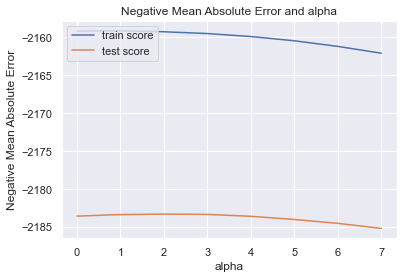

In [164]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
# plt.xscale('log')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [165]:
lasso_model.best_params_

{'alpha': 2.0}

In [166]:
lasso_model.best_score_

-2183.289101732138

In [167]:
# model with optimal alpha
# lasso regression
lm = Lasso(alpha=5)
lm.fit(X_train_pca, y_train)

# predict
y_train_pred = lm.predict(X_train_pca)

y_test_pred = lm.predict(X_test_pca)


In [168]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)

test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [169]:
print("Train Results for lasso Regression Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for lasso Regression Model:
--------------------------------------------------
Root mean squared error:  2682.784
Mean absolute error:  2164.058
Mean squared error:  7197328.037
R-squared:  0.999


In [170]:
print("Test Results for lasso Regression Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for lasso Regression Model:
--------------------------------------------------
Root mean squared error:  2734.605
Mean absolute error:  2216.676
Mean squared error:  7478066.873
R-squared:  0.999


In [171]:
model_results.loc[-1] = ["Lasso Regression",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0  Lasso Regression     0.999   2164.058    0.999  2216.676
1  Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 3- SGD Regressor

In [172]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.0001, average=True, early_stopping=True, epsilon=0.2,
       eta0=0.12, fit_intercept=True, l1_ratio=0.25,
       learning_rate='invscaling', loss='squared_loss', max_iter=10,n_iter_no_change=5, penalty='l1', power_t=0.22,
       random_state=15, shuffle=True, tol=None, validation_fraction=0.1,
        warm_start=False)



folds = KFold(n_splits = 7, shuffle = True, random_state = 4)
sgd_mod = RandomizedSearchCV(estimator = sgd, param_distributions ={} , cv =folds, scoring = 'neg_mean_squared_error',n_jobs = -1,verbose = 1,
                             return_train_score = True,random_state = 30)


In [173]:
sgd_mod.fit(X_train, y_train)

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.3s finished


RandomizedSearchCV(cv=KFold(n_splits=7, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=True,
                                          early_stopping=True, epsilon=0.2,
                                          eta0=0.12, fit_intercept=True,
                                          l1_ratio=0.25,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=10,
                                          n_iter_no_change=5, penalty='l1',
                                          power_t=0.22, random_state=15,
                                          shuffle=True, tol=None,
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1, param_distributions={},
                   pre_d

In [174]:
# print best hyperparameters
print("Best neg-MAE: ", sgd_mod.best_score_)
print("Best hyperparameters: ", sgd_mod.best_estimator_)

Best neg-MAE:  -47604394.554052174
Best hyperparameters:  SGDRegressor(alpha=0.0001, average=True, early_stopping=True, epsilon=0.2,
             eta0=0.12, fit_intercept=True, l1_ratio=0.25,
             learning_rate='invscaling', loss='squared_loss', max_iter=10,
             n_iter_no_change=5, penalty='l1', power_t=0.22, random_state=15,
             shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [175]:
y_train_pred = sgd_mod.predict(X_train)
y_test_pred = sgd_mod.predict(X_test)

In [176]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [177]:
print("Train Results for SGDRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for SGDRegressor Model:
--------------------------------------------------
Root mean squared error:  2282.506
Mean absolute error:  1752.707
Mean squared error:  5209835.273
R-squared:  0.999


In [178]:
print("Test Results for SGDRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for SGDRegressor Model:
--------------------------------------------------
Root mean squared error:  2363.219
Mean absolute error:  1805.277
Mean squared error:  5584802.55
R-squared:  0.999


In [179]:
filename = 'sgd_mod.sav'
pickle.dump(sgd_mod, open(filename, 'wb'))

In [180]:
filename = 'sgd_mod.sav'
xgb_model = pickle.load(open(filename, 'rb'))

In [181]:
model_results.loc[-1] = ["SGD Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0     SGD Regressor     0.999   1752.707    0.999  1805.277
1  Lasso Regression     0.999   2164.058    0.999  2216.676
2  Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 4- MLP Regressor


In [182]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.7,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.8,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=30, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
mlp_reg = RandomizedSearchCV(estimator = mlp, param_distributions ={} , cv =folds, scoring = 'neg_mean_squared_error',n_jobs = -1,verbose = 1,
                             return_train_score = True,random_state = 30)


In [183]:
mlp_reg.fit(X_train_pca, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.7,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08, hidden_layer_sizes=100,
                                          learning_rate='constant',
                                          learning_rate_init=0.001, max_iter=20,
                                          momentum=0.8, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_state=30, shuffle=True,
                                          solver='lbfgs', tol=0.0001,
                                          validation_fraction=0.1, verbose=True,
                                        

In [184]:
y_train_pred = mlp_reg.predict(X_train_pca)
y_test_pred = mlp_reg.predict(X_test_pca)

In [185]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [186]:
print("Train Results for mlpRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for mlpRegressor Model:
--------------------------------------------------
Root mean squared error:  4866.471
Mean absolute error:  3798.926
Mean squared error:  23682543.307
R-squared:  0.996


In [187]:
print("Test Results for SGDRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for SGDRegressor Model:
--------------------------------------------------
Root mean squared error:  4921.809
Mean absolute error:  3840.762
Mean squared error:  24224205.965
R-squared:  0.996


In [188]:
model_results.loc[-1] = ["MLP Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0     MLP Regressor     0.996   3798.926    0.996  3840.762
1     SGD Regressor     0.999   1752.707    0.999  1805.277
2  Lasso Regression     0.999   2164.058    0.999  2216.676
3  Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 5- Decision Tree

In [189]:
!pip install poisson

In [190]:
from sklearn.tree import DecisionTreeRegressor
#Training the Model with default parameters
dtree = DecisionTreeRegressor(random_state = 1)
params = {"criterion": ["mse", "friedman_mse", "mae"],
          "min_samples_split": [6,7,8,9,10],
            "max_depth" : [12,13,14,15,16,17]
         }
  
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 3)

dtree_model = RandomizedSearchCV(estimator=dtree, cv=folds, param_distributions=params, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1,
                                return_train_score = True, random_state=42)

In [191]:
dtree_model.fit(X_train_pca,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.7s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=1,
                                                   splitter='best'),
                   i

In [192]:
dtree_model.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [193]:
y_train_pred = dtree_model.predict(X_train_pca)
y_test_pred = dtree_model.predict(X_test_pca)

In [194]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [195]:
print("Train Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  2802.454
Mean absolute error:  1040.606
Mean squared error:  7853745.79
R-squared:  0.999


In [196]:
print("Test Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  17900.281
Mean absolute error:  5064.15
Mean squared error:  320420043.203
R-squared:  0.948


In [197]:
model_results.loc[-1] = ["Decision Tree Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0  Decision Tree Regressor     0.999   1040.606    0.948  5064.150
1            MLP Regressor     0.996   3798.926    0.996  3840.762
2            SGD Regressor     0.999   1752.707    0.999  1805.277
3         Lasso Regression     0.999   2164.058    0.999  2216.676
4         Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 6- Random Forest Regressor

In [198]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(random_state= 42,warm_start= True)

In [199]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [38,40,42]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [34,35,36]
min_samples_split = [15,16,17,18]
min_samples_leaf = [1, 2, 5]

In [200]:
#Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [201]:
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 8)
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error',
                              cv = folds, verbose=1, random_state=42, n_jobs = -1)

In [202]:
rf_random.fit(X_train_pca,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='...
                                                   random_state=42, verbose=0,
     

In [203]:
rf_random.best_params_

{'n_estimators': 40,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 35}

In [204]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=True)

In [205]:
y_train_pred = rf_random.predict(X_train_pca)
y_test_pred = rf_random.predict(X_test_pca)

In [206]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [207]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  5536.023
Mean absolute error:  2882.029
Mean squared error:  30647555.888
R-squared:  0.995


In [208]:
print("Test Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  11196.958
Mean absolute error:  5597.336
Mean squared error:  125371858.713
R-squared:  0.979


In [209]:
model_results.loc[-1] = ["Random Forest Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0  Random Forest Regressor     0.995   2882.029    0.979  5597.336
1  Decision Tree Regressor     0.999   1040.606    0.948  5064.150
2            MLP Regressor     0.996   3798.926    0.996  3840.762
3            SGD Regressor     0.999   1752.707    0.999  1805.277
4         Lasso Regression     0.999   2164.058    0.999  2216.676
5         Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 7- XGBoost Regression

In [210]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import xgboost

xgb = xgboost.XGBRegressor(random_state=42,n_estimators=120)

params = {
    "gamma": [21,22],
        "max_depth": [8,10],
        "learning_rate": [0.1,0.2],
        "n_estimators": [60],
        "max_depth": [13,14,15,16],
        "learning_rate": [0.17,0.18,0.19,0.2],
        "child_weight": [23,24],
      }
# max_depth, min_child_weight and gamma.

# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

xgb_model = RandomizedSearchCV(estimator=xgb, param_distributions=params, cv=folds, scoring = 'neg_mean_absolute_error',n_jobs = -1, 
                               verbose = 1, return_train_score = True, random_state=42)

# n_iter=50, 

In [211]:
# fit model
xgb_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   56.7s finished


[10:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "child_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          mi...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                

In [212]:
xgb_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', child_weight=24,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=22, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.18, max_delta_step=0,
             max_depth=13, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=60, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [213]:
y_train_pred = xgb_model.predict(X_train_pca)
y_test_pred = xgb_model.predict(X_test_pca)

In [214]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [215]:
print("Train Results for Xgboost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for Xgboost Regressor Model:
--------------------------------------------------
Root mean squared error:  80.493
Mean absolute error:  48.676
Mean squared error:  6479.142
R-squared:  1.0


In [216]:
print("Test Results for Xgboost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for Xgboost Regressor Model:
--------------------------------------------------
Root mean squared error:  10133.92
Mean absolute error:  3276.087
Mean squared error:  102696337.982
R-squared:  0.983


In [217]:
model_results.loc[-1] = ["Xgboost Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0        Xgboost Regressor     1.000     48.676    0.983  3276.087
1  Random Forest Regressor     0.995   2882.029    0.979  5597.336
2  Decision Tree Regressor     0.999   1040.606    0.948  5064.150
3            MLP Regressor     0.996   3798.926    0.996  3840.762
4            SGD Regressor     0.999   1752.707    0.999  1805.277
5         Lasso Regression     0.999   2164.058    0.999  2216.676
6         Ridge Regression     0.999   2162.117    0.999  2212.014

**Save model**

In [218]:
filename = 'xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

In [219]:
filename = 'xgb_model.sav'
xgb_model = pickle.load(open(filename, 'rb'))

### <a> Model 8- KNN Regressor

In [220]:
knn = KNeighborsRegressor()
k_range = list(range(1, 30))
params = dict(n_neighbors = k_range)

# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

knn_regressor = GridSearchCV(knn, params, cv =folds, scoring = 'neg_mean_squared_error',n_jobs = -1, 
                               verbose = 1, return_train_score = True)
knn_regressor.fit(X_train_pca, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:   33.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=1)

In [221]:
knn_regressor.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [222]:
y_train_pred = knn_regressor.predict(X_train_pca)
y_test_pred = knn_regressor.predict(X_test_pca)

In [223]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [224]:
print("Train Results for Knn Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", train_r2)

Train Results for Knn Model:
--------------------------------------------------
Root mean squared error:  5072.416
Mean absolute error:  1.158
Mean squared error:  25729403.193
R-squared:  1.0


In [225]:
print("Test Results for Knn Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for Knn Model:
--------------------------------------------------
Root mean squared error:  5072.416
Mean absolute error:  714.322
Mean squared error:  25729403.193
R-squared:  0.996


In [226]:
model_results.loc[-1] = ["Knn",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0                      Knn     1.000      1.158    0.996   714.322
1        Xgboost Regressor     1.000     48.676    0.983  3276.087
2  Random Forest Regressor     0.995   2882.029    0.979  5597.336
3  Decision Tree Regressor     0.999   1040.606    0.948  5064.150
4            MLP Regressor     0.996   3798.926    0.996  3840.762
5            SGD Regressor     0.999   1752.707    0.999  1805.277
6         Lasso Regression     0.999   2164.058    0.999  2216.676
7         Ridge Regression     0.999   2162.117    0.999  2212.014

**Save model**

In [227]:
filename = 'knn_regressor.sav'
pickle.dump(knn_regressor, open(filename, 'wb'))

In [228]:
knn_model = pickle.load(open(filename, 'rb'))

### <a> Model 9- SVM Regressor

In [229]:
# Import SVM Regressor
from sklearn import svm

# Create a SVM Regressor
svc = svm.SVR()

# Support Vector Classifier 
params = {'C': [40,45,48,50,52],
            'max_iter':    [300,500,700],
            'kernel': ['rbf', 'linear','poly']
#            'epsilon' : [0.15,0.2,0.3,0.40,45,0.5,0.52,0.55,0.58,0.60],'degree':[2,3,4,5,6]
         }
            
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

svc_model = RandomizedSearchCV(estimator=svc, cv=folds, param_distributions=params, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1,random_state = 42)

In [230]:
# Train the model using the training sets 
svc_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [40, 45, 48, 50, 52],
                                        'kernel': ['rbf', 'linear', 'poly'],
                                        'max_iter': [300, 500, 700]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=1)

In [231]:
# We automatically get the SVR with the best parameters.
svc_model.best_estimator_

SVR(C=52, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=700, shrinking=True,
    tol=0.001, verbose=False)

In [232]:
# print best hyperparameters
print("MSE: ", svc_model.best_score_)
print("Best hyperparameters: ", svc_model.best_params_)

MSE:  -17313720.388120677
Best hyperparameters:  {'max_iter': 700, 'kernel': 'linear', 'C': 52}


In [233]:
y_train_pred = svc_model.predict(X_train_pca)
y_test_pred = svc_model.predict(X_test_pca)

In [234]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [235]:
print("Train Results for SVC Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", train_r2)

Train Results for SVC Regressor Model:
--------------------------------------------------
Root mean squared error:  3732.0
Mean absolute error:  3140.352
Mean squared error:  13927826.268
R-squared:  0.998


In [236]:
print("Test Results for SVC Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for SVC Regressor Model:
--------------------------------------------------
Root mean squared error:  3732.0
Mean absolute error:  3176.56
Mean squared error:  13927826.268
R-squared:  0.998


In [237]:
model_results.loc[-1] = ["SVC Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0            SVC Regressor     0.998   3140.352    0.998  3176.560
1                      Knn     1.000      1.158    0.996   714.322
2        Xgboost Regressor     1.000     48.676    0.983  3276.087
3  Random Forest Regressor     0.995   2882.029    0.979  5597.336
4  Decision Tree Regressor     0.999   1040.606    0.948  5064.150
5            MLP Regressor     0.996   3798.926    0.996  3840.762
6            SGD Regressor     0.999   1752.707    0.999  1805.277
7         Lasso Regression     0.999   2164.058    0.999  2216.676
8         Ridge Regression     0.999   2162.117    0.999  2212.014

### <a> Model 10- CatBoost Regressor

In [238]:
!pip install catboost

In [240]:
### This part of code takes hours to run so have commented it

import catboost as cb
cat = cb.CatBoostRegressor(loss_function='RMSE')
params = {'depth' : [6,7],
          'learning_rate' : [0.138,0.14],
          'iterations'    : [1000,1200],
          'random_strength':[1],
          'bagging_temperature': [5,10]
         }


# # create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

cat_model = RandomizedSearchCV(estimator=cat, cv=folds, param_distributions=params, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1,random_state = 42)
cat_model.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.2min finished


0:	learn: 70973.3156253	total: 159ms	remaining: 3m 10s
1:	learn: 64687.8217079	total: 168ms	remaining: 1m 40s
2:	learn: 59204.6911448	total: 176ms	remaining: 1m 10s
3:	learn: 54359.5250155	total: 185ms	remaining: 55.2s
4:	learn: 49790.1770479	total: 194ms	remaining: 46.4s
5:	learn: 45642.7962649	total: 203ms	remaining: 40.4s
6:	learn: 41744.3362483	total: 212ms	remaining: 36s
7:	learn: 38460.3203870	total: 220ms	remaining: 32.8s
8:	learn: 36103.5378403	total: 229ms	remaining: 30.3s
9:	learn: 33503.9840691	total: 238ms	remaining: 28.3s
10:	learn: 31555.2335335	total: 246ms	remaining: 26.6s
11:	learn: 29461.0498364	total: 255ms	remaining: 25.2s
12:	learn: 27695.0964658	total: 263ms	remaining: 24s
13:	learn: 26181.4802629	total: 271ms	remaining: 23s
14:	learn: 24583.4694222	total: 279ms	remaining: 22s
15:	learn: 23345.0390710	total: 289ms	remaining: 21.4s
16:	learn: 22276.1629198	total: 299ms	remaining: 20.8s
17:	learn: 21205.8346380	total: 307ms	remaining: 20.2s
18:	learn: 20329.5269657	

158:	learn: 4546.8258219	total: 1.41s	remaining: 9.24s
159:	learn: 4533.6301794	total: 1.42s	remaining: 9.21s
160:	learn: 4503.7645600	total: 1.42s	remaining: 9.18s
161:	learn: 4487.0143135	total: 1.43s	remaining: 9.15s
162:	learn: 4465.3667321	total: 1.43s	remaining: 9.12s
163:	learn: 4449.3859625	total: 1.44s	remaining: 9.09s
164:	learn: 4435.8785274	total: 1.44s	remaining: 9.05s
165:	learn: 4414.6854816	total: 1.45s	remaining: 9.03s
166:	learn: 4396.9930216	total: 1.45s	remaining: 8.99s
167:	learn: 4379.2234251	total: 1.46s	remaining: 8.96s
168:	learn: 4362.2151134	total: 1.46s	remaining: 8.93s
169:	learn: 4342.2876540	total: 1.47s	remaining: 8.9s
170:	learn: 4327.6417096	total: 1.48s	remaining: 8.88s
171:	learn: 4305.7920975	total: 1.48s	remaining: 8.85s
172:	learn: 4283.9951318	total: 1.49s	remaining: 8.82s
173:	learn: 4267.7828718	total: 1.49s	remaining: 8.79s
174:	learn: 4247.9090064	total: 1.5s	remaining: 8.76s
175:	learn: 4233.6251074	total: 1.5s	remaining: 8.73s
176:	learn: 4

321:	learn: 2765.2271187	total: 2.28s	remaining: 6.22s
322:	learn: 2757.6834240	total: 2.29s	remaining: 6.21s
323:	learn: 2749.6909390	total: 2.29s	remaining: 6.2s
324:	learn: 2743.4981274	total: 2.3s	remaining: 6.19s
325:	learn: 2736.8374187	total: 2.3s	remaining: 6.17s
326:	learn: 2730.4677688	total: 2.31s	remaining: 6.16s
327:	learn: 2726.6842865	total: 2.31s	remaining: 6.15s
328:	learn: 2718.6354591	total: 2.32s	remaining: 6.14s
329:	learn: 2714.4337725	total: 2.32s	remaining: 6.13s
330:	learn: 2710.4532232	total: 2.33s	remaining: 6.12s
331:	learn: 2706.5495886	total: 2.34s	remaining: 6.11s
332:	learn: 2700.5743704	total: 2.34s	remaining: 6.09s
333:	learn: 2696.8466608	total: 2.35s	remaining: 6.08s
334:	learn: 2691.6871952	total: 2.35s	remaining: 6.07s
335:	learn: 2685.2567278	total: 2.36s	remaining: 6.06s
336:	learn: 2680.4629293	total: 2.36s	remaining: 6.05s
337:	learn: 2676.2270590	total: 2.37s	remaining: 6.04s
338:	learn: 2667.6977909	total: 2.37s	remaining: 6.03s
339:	learn: 2

486:	learn: 2011.6081288	total: 3.17s	remaining: 4.64s
487:	learn: 2006.6030014	total: 3.17s	remaining: 4.63s
488:	learn: 2001.6249589	total: 3.18s	remaining: 4.62s
489:	learn: 1997.2446533	total: 3.18s	remaining: 4.61s
490:	learn: 1992.8959440	total: 3.19s	remaining: 4.6s
491:	learn: 1989.5351556	total: 3.19s	remaining: 4.6s
492:	learn: 1985.6590199	total: 3.2s	remaining: 4.59s
493:	learn: 1983.2338804	total: 3.21s	remaining: 4.58s
494:	learn: 1981.2693388	total: 3.21s	remaining: 4.57s
495:	learn: 1976.4053244	total: 3.21s	remaining: 4.56s
496:	learn: 1971.7107239	total: 3.22s	remaining: 4.55s
497:	learn: 1967.8227830	total: 3.23s	remaining: 4.55s
498:	learn: 1961.9533752	total: 3.23s	remaining: 4.54s
499:	learn: 1960.3282832	total: 3.24s	remaining: 4.53s
500:	learn: 1957.5074130	total: 3.24s	remaining: 4.52s
501:	learn: 1952.5955223	total: 3.25s	remaining: 4.51s
502:	learn: 1949.5760305	total: 3.25s	remaining: 4.51s
503:	learn: 1946.4411052	total: 3.26s	remaining: 4.5s
504:	learn: 19

644:	learn: 1582.9437214	total: 4.04s	remaining: 3.47s
645:	learn: 1578.6403089	total: 4.04s	remaining: 3.47s
646:	learn: 1576.5037046	total: 4.05s	remaining: 3.46s
647:	learn: 1574.3601260	total: 4.05s	remaining: 3.45s
648:	learn: 1572.4676331	total: 4.06s	remaining: 3.45s
649:	learn: 1569.4465752	total: 4.07s	remaining: 3.44s
650:	learn: 1567.5378516	total: 4.07s	remaining: 3.43s
651:	learn: 1565.3152992	total: 4.08s	remaining: 3.43s
652:	learn: 1563.2498531	total: 4.08s	remaining: 3.42s
653:	learn: 1560.2551060	total: 4.09s	remaining: 3.42s
654:	learn: 1558.2206634	total: 4.1s	remaining: 3.41s
655:	learn: 1556.4970966	total: 4.1s	remaining: 3.4s
656:	learn: 1554.7514704	total: 4.11s	remaining: 3.4s
657:	learn: 1552.9534272	total: 4.11s	remaining: 3.39s
658:	learn: 1551.1271699	total: 4.12s	remaining: 3.38s
659:	learn: 1549.2009457	total: 4.13s	remaining: 3.38s
660:	learn: 1545.8970482	total: 4.13s	remaining: 3.37s
661:	learn: 1543.2084327	total: 4.14s	remaining: 3.36s
662:	learn: 15

818:	learn: 1270.2383513	total: 5.1s	remaining: 2.37s
819:	learn: 1268.8978691	total: 5.11s	remaining: 2.37s
820:	learn: 1266.7103607	total: 5.12s	remaining: 2.36s
821:	learn: 1265.7761613	total: 5.13s	remaining: 2.36s
822:	learn: 1264.5339023	total: 5.13s	remaining: 2.35s
823:	learn: 1262.1726032	total: 5.14s	remaining: 2.35s
824:	learn: 1260.2992610	total: 5.15s	remaining: 2.34s
825:	learn: 1258.7490313	total: 5.15s	remaining: 2.33s
826:	learn: 1257.0845307	total: 5.16s	remaining: 2.33s
827:	learn: 1255.3678281	total: 5.17s	remaining: 2.32s
828:	learn: 1252.9337295	total: 5.18s	remaining: 2.32s
829:	learn: 1251.2508851	total: 5.18s	remaining: 2.31s
830:	learn: 1250.0284900	total: 5.19s	remaining: 2.31s
831:	learn: 1248.6860949	total: 5.2s	remaining: 2.3s
832:	learn: 1246.8345610	total: 5.21s	remaining: 2.29s
833:	learn: 1245.7002997	total: 5.21s	remaining: 2.29s
834:	learn: 1244.0036900	total: 5.22s	remaining: 2.28s
835:	learn: 1243.4851706	total: 5.23s	remaining: 2.28s
836:	learn: 1

985:	learn: 1041.5177152	total: 6.34s	remaining: 1.38s
986:	learn: 1040.4552764	total: 6.35s	remaining: 1.37s
987:	learn: 1039.8519533	total: 6.35s	remaining: 1.36s
988:	learn: 1039.1608741	total: 6.36s	remaining: 1.36s
989:	learn: 1038.3477528	total: 6.37s	remaining: 1.35s
990:	learn: 1037.4350859	total: 6.37s	remaining: 1.34s
991:	learn: 1036.7439633	total: 6.38s	remaining: 1.34s
992:	learn: 1036.1655387	total: 6.38s	remaining: 1.33s
993:	learn: 1034.5334547	total: 6.39s	remaining: 1.32s
994:	learn: 1033.6677304	total: 6.39s	remaining: 1.32s
995:	learn: 1033.0401784	total: 6.4s	remaining: 1.31s
996:	learn: 1032.0460593	total: 6.4s	remaining: 1.3s
997:	learn: 1031.0126308	total: 6.41s	remaining: 1.3s
998:	learn: 1029.9431547	total: 6.41s	remaining: 1.29s
999:	learn: 1029.1438821	total: 6.42s	remaining: 1.28s
1000:	learn: 1028.1625428	total: 6.42s	remaining: 1.28s
1001:	learn: 1027.2256176	total: 6.43s	remaining: 1.27s
1002:	learn: 1026.0519064	total: 6.43s	remaining: 1.26s
1003:	learn

1134:	learn: 898.7599485	total: 7.23s	remaining: 414ms
1135:	learn: 898.2345224	total: 7.23s	remaining: 408ms
1136:	learn: 897.4786033	total: 7.24s	remaining: 401ms
1137:	learn: 896.8847500	total: 7.25s	remaining: 395ms
1138:	learn: 896.3511287	total: 7.25s	remaining: 388ms
1139:	learn: 895.0145911	total: 7.26s	remaining: 382ms
1140:	learn: 893.8626801	total: 7.26s	remaining: 376ms
1141:	learn: 893.0300609	total: 7.27s	remaining: 369ms
1142:	learn: 891.9276622	total: 7.28s	remaining: 363ms
1143:	learn: 890.5176146	total: 7.28s	remaining: 357ms
1144:	learn: 889.8489266	total: 7.29s	remaining: 350ms
1145:	learn: 889.1836299	total: 7.3s	remaining: 344ms
1146:	learn: 888.2298162	total: 7.3s	remaining: 337ms
1147:	learn: 887.4768889	total: 7.31s	remaining: 331ms
1148:	learn: 886.6358557	total: 7.32s	remaining: 325ms
1149:	learn: 885.7253187	total: 7.32s	remaining: 318ms
1150:	learn: 885.1102765	total: 7.33s	remaining: 312ms
1151:	learn: 884.2962223	total: 7.33s	remaining: 306ms
1152:	learn:

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000021E05E2BD08>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'bagging_temperature': [5, 10],
                                        'depth': [6, 7],
                                        'iterations': [1000, 1200],
                                        'learning_rate': [0.138, 0.14],
                                        'random_strength': [1]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=1)

In [235]:
# We automatically get the SVR with the best parameters.
cat_model.best_estimator_


In [236]:
# print best hyperparameters
print("MSE: ", cat_model.best_score_)
print("Best hyperparameters: ", cat_model.best_params_)

MSE:  -18098881.54472719
Best hyperparameters:  {'random_strength': 1, 'learning_rate': 0.14, 'iterations': 1200, 'depth': 6, 'bagging_temperature': 10}


In [237]:
y_train_pred = cat_model.predict(X_train_pca)
y_test_pred = cat_model.predict(X_test_pca)

In [238]:
train_mae = round(mean_absolute_error(y_train.values, y_train_pred),3)
train_r2 = round(r2_score(y_train.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test.values, y_test_pred),3)
test_r2 = round(r2_score(y_test.values, y_test_pred),3)

In [239]:
print("Train Results for CatBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for CatBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  737.308
Mean absolute error:  524.586
Mean squared error:  543622.611
R-squared:  1.0


In [240]:
print("Test Results for CatBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for CatBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  3395.828
Mean absolute error:  1756.857
Mean squared error:  11531647.949
R-squared:  0.998


In [241]:
model_results.loc[-1] = ["CatBoost Regressor",train_r2,train_mae,test_r2,test_mae]
model_results.index = model_results.index + 1  # shifting index
model_results = model_results.sort_index()  # sorting by index
model_results

Model Name  Train R2  Train MAE  Test R2  Test MAE
0       CatBoost Regressor     1.000    524.586    0.998  1756.857
1            SVC Regressor     0.998   2941.927    0.998  2974.582
2                      Knn     1.000      0.921    0.991  1133.553
3        Xgboost Regressor     1.000    103.999    0.993  2017.389
4  Random Forest Regressor     0.996   2032.324    0.988  3703.585
5            MLP Regressor     0.995   4187.926    0.995  4159.600
6            SGD Regressor     0.999   2193.268    0.999  2229.082
7         Lasso Regression     0.999   2196.623    0.999  2246.860
8         Ridge Regression     0.999   2197.549    0.999  2243.425

**Save model**

In [244]:
filename = 'cat_model.pkl'
pickle.dump(cat_model, open(filename, 'wb'))

In [245]:
filename = 'cat_model.sav'
cat_model = pickle.load(open(filename, 'rb'))

____________________________________

All th above models has overfitting problems even after fine tuning. To try another approach, I have tried modelling using Pycaret as well. AFter tuning Extra Tree regressor model , we might get better results.

### With PyCaret: AutoML Library

In [255]:
a = (((Out_Cities.columns).append(Out_Airline.columns)).append(Dest_Cities.columns))

In [378]:
from pycaret.regression import *

In [396]:
exp_reg = setup(
                df,           # passing the pandas dataframe for training
                target='Target_Var', # telling which one is Target feature
              train_size=0.7,transformation=True, remove_multicollinearity= True, transform_target=True,
                normalize = True)

 
Setup Succesfully Completed.


In [397]:
# Comparing all models using compare_models()
#This function trains and evaluates performance of all estimators available in the model library using cross validation.

comp_model = compare_models(sort = 'RMSE',fold = 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6650 entries, 0 to 6649
Columns: 109 entries, Out_Day to AvgPrice
dtypes: float64(2), int64(9), uint8(98)
memory usage: 1.5 MB


In [181]:
# Putting feature variables to X
X1 = data.copy()

# Putting response variable to y
y1 = X1.pop('Price')

In [182]:
# Let us split our dataset into train & yest
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=0.7 , random_state=100)

In [183]:
X_train1.head()

Out_Day  Out_Weekday  Out_Month  Out_Travel_Time  Out_Journey_Type  \
1934        2            4          7              130                 0   
1012       28            2          4              150                 0   
1119       15            6          8              120                 0   
6178       10            1          8              430                 1   
6222       21            4          5              200                 0   

      sort  Target_Var  Out_hour  Out_min  Out_Cities_AMD  Out_Cities_ATQ  \
1934     2      119013         8       20               0               0   
1012     2       24494        23        0               0               0   
1119     0      181305        17       10               0               0   
6178     2      174809        23       30               0               0   
6222     1       56006        13       20               0               0   

      Out_Cities_BBI  Out_Cities_BDQ  Out_Cities_BHO  Out_Cities_BKB  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_BLR  Out_Cities_BOM  Out_Cities_CCJ  Out_Cities_CCU  \
1934               0               0               0               1   
1012               1               0               0               0   
1119               1               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_CJB  Out_Cities_CNN  Out_Cities_DED  Out_Cities_DEL  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_GAU  Out_Cities_GAY  Out_Cities_GOI  Out_Cities_HBX  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_HYD  Out_Cities_IDR  Out_Cities_IMF  Out_Cities_ISK  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXC  Out_Cities_IXE  Out_Cities_IXL  Out_Cities_IXM  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_IXR  Out_Cities_JAI  Out_Cities_LKO  Out_Cities_MAA  \
1934               0               0               0               0   
1012               0               0               0               0   
1119               0               0               0               0   
6178               0               0               0               0   
6222               0               0               0               0   

      Out_Cities_NAG  Out_Cities_PAT  Out_Cities_PNQ  O

In [184]:
X_train1.shape

(4655, 106)

In [185]:
from sklearn.linear_model import SGDRegressor
sgd1 = SGDRegressor(alpha=0.0001, average=True, early_stopping=True, epsilon=0.2,
       eta0=0.12, fit_intercept=True, l1_ratio=0.25,
       learning_rate='invscaling', loss='squared_loss', max_iter=10,n_iter_no_change=5, penalty='l1', power_t=0.22,
       random_state=15, shuffle=True, tol=None, validation_fraction=0.1,
        warm_start=False)



folds = KFold(n_splits = 7, shuffle = True, random_state = 4)
sgd_mod1 = RandomizedSearchCV(estimator = sgd1, param_distributions ={} , cv =folds, scoring = 'neg_mean_squared_error',n_jobs = -1,verbose = 1,
                             return_train_score = True,random_state = 30)

In [186]:
sgd_mod1.fit(X_train1, y_train1)

Fitting 7 folds for each of 1 candidates, totalling 7 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.9s finished


RandomizedSearchCV(cv=KFold(n_splits=7, random_state=4, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=True,
                                          early_stopping=True, epsilon=0.2,
                                          eta0=0.12, fit_intercept=True,
                                          l1_ratio=0.25,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=10,
                                          n_iter_no_change=5, penalty='l1',
                                          power_t=0.22, random_state=15,
                                          shuffle=True, tol=None,
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='warn', n_iter=10, n_jobs=-1, param_distributions={},
                   pre_d

In [187]:
y_train_pred = sgd_mod1.predict(X_train1)
y_test_pred = sgd_mod1.predict(X_test1)

In [188]:
train_mae = round(mean_absolute_error(y_train1.values, y_train_pred),3)
train_r2 = round(r2_score(y_train1.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test1.values, y_test_pred),3)
test_r2 = round(r2_score(y_test1.values, y_test_pred),3)

In [189]:
print("Train Results for SGDRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train1.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train1.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for SGDRegressor Model:
--------------------------------------------------
Root mean squared error:  7.74496253222683e+17
Mean absolute error:  5.981056716065533e+17
Mean squared error:  5.9984444625597424e+35
R-squared:  -2.1965808945287766e+28


In [190]:
print("Test Results for SGDRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_test.values, y_test_pred)),3))
print("Mean absolute error: ",test_mae)
print("Mean squared error: ",round(mean_squared_error(y_test.values, y_test_pred),3))
print("R-squared: ", test_r2)

Test Results for SGDRegressor Model:
--------------------------------------------------
Root mean squared error:  7.770693426619259e+17
Mean absolute error:  6.031604307392745e+17
Mean squared error:  6.038367633050376e+35
R-squared:  -2.826695693655946e+28


In [191]:
filename = 'sgd_mod1.pkl'
pickle.dump(sgd_mod1, open(filename, 'wb'))

In [192]:
filename = 'sgd_mod1.pkl'
sgd_mod1 = pickle.load(open(filename, 'rb'))

In [193]:
from sklearn.ensemble import RandomForestRegressor
reg_rf1 = RandomForestRegressor(random_state= 42,warm_start= True)

In [194]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [38,40,42]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
max_depth = [34,35,36]
min_samples_split = [15,16,17,18]
min_samples_leaf = [1, 2, 5]

In [195]:
#Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [196]:
# create 5 folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 8)
# search across 100 different combinations
rf_random_1 = RandomizedSearchCV(estimator = reg_rf1, param_distributions = random_grid,scoring='neg_mean_squared_error',
                              cv = folds, verbose=1, random_state=42, n_jobs = -1)

In [197]:
rf_random_1.fit(X_train1,y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='...
                                                   random_state=42, verbose=0,
     

In [198]:
y_train_pred = rf_random_1.predict(X_train1)
y_test_pred = rf_random_1.predict(X_test1)

In [199]:
train_mae = round(mean_absolute_error(y_train1.values, y_train_pred),3)
train_r2 = round(r2_score(y_train1.values, y_train_pred),3)


test_mae = round(mean_absolute_error(y_test1.values, y_test_pred),3)
test_r2 = round(r2_score(y_test1.values, y_test_pred),3)

In [200]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", round(sqrt(mean_squared_error(y_train1.values, y_train_pred)),3))
print("Mean absolute error: ",train_mae)
print("Mean squared error: ",round(mean_squared_error(y_train1.values, y_train_pred),3))
print("R-squared: ", train_r2)

Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  2246.695
Mean absolute error:  564.268
Mean squared error:  5047638.008
R-squared:  0.815


In [201]:
filename = 'rf_random_1.pkl'
pickle.dump(rf_random_1, open(filename, 'wb'))